In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, PowerTransformer, RobustScaler, MinMaxScaler, QuantileTransformer, StandardScaler, FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline

le = LabelEncoder()
cur_date = pd.Timestamp.now()

# Predspracovanie údajov pre strojové učenie 
# Sližik, Ürge (50 : 50) - dataset 027 
## Extrakcia dát
Pre túto fázu sme sa rozhodli pracovať čisto s datasetom sessions
 * products nedokážeme nijako mergenúť 
 * users obsahujú duplikátne id, a teda na to, aby sme spojili products s users by sme duplikátne id museli dropnúť, avšak po inner mergenutí by sme prišli o viacej ako 50% sessions, čo by nemuselo byť veľmi dobré pre náš model, keďže dáta v sessions najviac ovplyvňujú `ack`, ako sme zistili v prvej fáze

Po načítaní odstránime duplikátne riadky spolu s nepotrebnými id columns `product_ean`, `session_id`, `user_id`.

In [65]:
def drop_extra(dataframe):
    dataframe = dataframe.drop_duplicates()
    dataframe = dataframe.drop(columns=['product_ean', 'session_id', 'user_id'])
    return dataframe

sessions = pd.read_csv("027/session.csv", encoding="utf_8", sep='\t')
sessions = drop_extra(sessions)

## Integrácia a čistenie dát
Naším cieľom je premeniť všetky dáta numerické hodnoty, očistiť ich od missing values za pomoci rôznych prístupov a odstrániť vychýlené hodnoty.  

In [66]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10928 entries, 0 to 11058
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        10917 non-null  float64
 1   pct_click_product_info          10917 non-null  float64
 2   pct_click                       10917 non-null  float64
 3   pct_rage_click                  10917 non-null  float64
 4   pct_mouse_move                  10917 non-null  float64
 5   wild_mouse_duration             10917 non-null  float64
 6   pct_wild_mouse                  10917 non-null  float64
 7   scroll_move_total_rel_distance  10917 non-null  float64
 8   pct_scrandom                    10917 non-null  float64
 9   total_load_time                 10928 non-null  float64
 10  screen_height                   10928 non-null  object 
 11  page_activity_duration          10917 non-null  float64
 12  pct_scroll_move                 10917

### Browser name Label Encoding
Na vyriešenie nahradenia enumových hodnôt pre `browser_name` sme sa rozhodli využiť metódu Label Encoding, kedy sa každej hodnote, ktorú môže enum nadobúdať priradí hodnota numerická.

In [67]:
def label_encoding(dataframe, column_name):
    dataframe[column_name] = le.fit_transform(dataframe[column_name])

    for encoded_value in set(dataframe[column_name]):
        original_value = le.inverse_transform([encoded_value])[0]
        print(f"Encoded Value: {encoded_value}, Original Value: {original_value}")

label_encoding(sessions, 'browser_name')

Encoded Value: 0, Original Value: chrome
Encoded Value: 1, Original Value: edge
Encoded Value: 2, Original Value: firefox
Encoded Value: 3, Original Value: mobile
Encoded Value: 4, Original Value: opera
Encoded Value: 5, Original Value: other
Encoded Value: 6, Original Value: safari


### Nenumerické hodnoty screen width, screen height následne aplikujeme Label Encoding 
Z EDA v predošlej fáze vieme, že `screen_width` a `screen_height` môžu nadobúdať okrem numerických hodnôt aj hodnoty `higher` a `lower` je preto potrebné ich nahradiť numerickými hodnotami - na to, aby sa zachovala koherentnosť možných hodnôt, ktoré stĺpce môžu nadobúdať sme sa rozhodli `higher` nahradiť max hodnotou a `lower` nahradiť min hodnotou stĺpca. Následne hodnoty zaencodujeme.

In [68]:
def process_session_screen_sizes(dataframe):
    screen_width_data = list(sessions["screen_width"].unique())
    screen_width_numeric_values = [int(value) for value in screen_width_data if value.isdigit()]
    min_width = str(min(screen_width_numeric_values, default=None))
    max_width = str(max(screen_width_numeric_values, default=None))
    
    screen_height_data = list(sessions["screen_height"].unique())
    screen_height_numeric_values = [int(value) for value in screen_height_data if value.isdigit()]
    min_height = str(min(screen_height_numeric_values, default=None))
    max_height= str(max(screen_height_numeric_values, default=None))
    
    dataframe["screen_width"]=dataframe["screen_width"].str.replace("lower", min_width)
    dataframe["screen_width"]=dataframe["screen_width"].str.replace("higher", max_width)
    dataframe["screen_height"]=dataframe["screen_height"].str.replace("lower", min_height)    
    dataframe["screen_height"]=dataframe["screen_height"].str.replace("higher", max_height)
    
    dataframe["screen_height"] = pd.to_numeric(sessions["screen_height"], errors='coerce')
    dataframe["screen_width"] = pd.to_numeric(sessions["screen_width"], errors='coerce')
    return dataframe

sessions = process_session_screen_sizes(sessions)
print("Variable: screen_height")
label_encoding(sessions, 'screen_height')
print("Variable: screen_width") 
label_encoding(sessions, 'screen_width')

Variable: screen_height
Encoded Value: 0, Original Value: 600
Encoded Value: 1, Original Value: 768
Encoded Value: 2, Original Value: 800
Encoded Value: 3, Original Value: 1024
Encoded Value: 4, Original Value: 1080
Variable: screen_width
Encoded Value: 0, Original Value: 800
Encoded Value: 1, Original Value: 1024
Encoded Value: 2, Original Value: 1280
Encoded Value: 3, Original Value: 1366
Encoded Value: 4, Original Value: 1920


### Rozbitie dátumu Session start na hour of day a month
Náš dataset obsahuje aj jeden dátum `session_start`, ktorý by sme mohli dropnúť, avšak pokiaľ by sme tak urobili prišli by sme o potenciálne vzácne údaje o tom v ktorých hodinách a ktorých mesiacoch užívatelia interagovali s naším eshopom, čo by mohlo potenciálne ovplyvniť ich rozhodnutie preto sme sa tieto údaje rozhodli zachovať - zo `session_start` sa stávajú dva nové stĺpce `month` a `hour_of_day`. 

In [69]:
def process_session_start(dataframe):
    dataframe['session_start'] = pd.to_datetime(dataframe['session_start'])
    dataframe['hour_of_day'] = dataframe['session_start'].dt.hour
    dataframe['month'] = dataframe['session_start'].dt.month
    dataframe = dataframe.drop(columns=['session_start'])
    return dataframe

sessions = process_session_start(sessions)

### Kópia datasetu
Po prvotnom prečistení si vytvoríme kópiu datasetu, ktorá bude neskôr slúžiť pre porovnanie či zmeny, ktoré budeme nad naším datasetom vykonávať veľmi nepozmenia jeho celkovú koherentnosť.

In [70]:
original_sessions = sessions.copy()
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10928 entries, 0 to 11058
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        10917 non-null  float64
 1   pct_click_product_info          10917 non-null  float64
 2   pct_click                       10917 non-null  float64
 3   pct_rage_click                  10917 non-null  float64
 4   pct_mouse_move                  10917 non-null  float64
 5   wild_mouse_duration             10917 non-null  float64
 6   pct_wild_mouse                  10917 non-null  float64
 7   scroll_move_total_rel_distance  10917 non-null  float64
 8   pct_scrandom                    10917 non-null  float64
 9   total_load_time                 10928 non-null  float64
 10  screen_height                   10928 non-null  int64  
 11  page_activity_duration          10917 non-null  float64
 12  pct_scroll_move                 10917

### Vysporiadanie sa s nan stĺpcami 
Nan stĺpce si rozdelíme na tri časti - prvú časť doplníme pomocou kNN a druhú pomocou mediánu a tretiu pomocou mean hodnoty.

In [71]:
sessions.isnull().sum()

pct_scroll_move_duration          11
pct_click_product_info            11
pct_click                         11
pct_rage_click                    11
pct_mouse_move                    11
wild_mouse_duration               11
pct_wild_mouse                    11
scroll_move_total_rel_distance    11
pct_scrandom                      11
total_load_time                    0
screen_height                      0
page_activity_duration            11
pct_scroll_move                   11
session_duration                   0
pct_doubleclick                   11
ack                                0
mouse_move_total_rel_distance     11
pct_input                         11
screen_width                       0
browser_name                       0
pct_mouse_click                   11
hour_of_day                        0
month                              0
dtype: int64

In [72]:
null_cols = sessions.columns[sessions.isna().any()].tolist()
part_length = len(null_cols) // 3
null_cols1, null_cols2, null_cols3 = null_cols[:part_length], null_cols[part_length:2*part_length], null_cols[2*part_length:]

### Doplnenie nan hodnôt pomocou kNN
kNN odhaduje nan hodnoty na základe pozorovania patternu hodnôt `k` susedov a na základe ich hodnôt sa rozhodne ohodnotiť chýbajúcu hodnotu. Osvedčila sa nám defaultná hodnota `k=5` susedov, ktorá je defaultne nainicializovaná po zavolaní KNNImputera.

In [73]:
def replace_null_with_knn(dataframe, columns_with_missing_values):
    imputed_values = KNNImputer().fit_transform(dataframe[columns_with_missing_values])

    for i, column in enumerate(columns_with_missing_values):
        dataframe[column] = imputed_values[:, i]
    return dataframe

sessions = replace_null_with_knn(sessions, null_cols1)

### Doplnenie hodnôt pomocou mediánu

In [74]:
def replace_null_with_median(dataframe, columns_with_missing_values):
    median_values = dataframe[columns_with_missing_values].median()
    result_dataframe = dataframe.copy()
    result_dataframe[columns_with_missing_values] = result_dataframe[columns_with_missing_values].fillna(median_values)
    return result_dataframe

sessions = replace_null_with_median(sessions, null_cols2)

### Doplnenie hodnôt pomocou meanu

In [75]:
def replace_null_with_mean(dataframe, columns_with_missing_values):
    mean_values = dataframe[columns_with_missing_values].mean()
    result_dataframe = dataframe.copy()
    result_dataframe[columns_with_missing_values] = result_dataframe[columns_with_missing_values].fillna(mean_values)
    return result_dataframe

sessions = replace_null_with_mean(sessions, null_cols3)

In [76]:
sessions.isnull().sum()

pct_scroll_move_duration          0
pct_click_product_info            0
pct_click                         0
pct_rage_click                    0
pct_mouse_move                    0
wild_mouse_duration               0
pct_wild_mouse                    0
scroll_move_total_rel_distance    0
pct_scrandom                      0
total_load_time                   0
screen_height                     0
page_activity_duration            0
pct_scroll_move                   0
session_duration                  0
pct_doubleclick                   0
ack                               0
mouse_move_total_rel_distance     0
pct_input                         0
screen_width                      0
browser_name                      0
pct_mouse_click                   0
hour_of_day                       0
month                             0
dtype: int64

### Prekonvertovanie všetkých stĺpcov na jednotný dátový typ
Predtým než budeme riešiť vychýlené hodnoty ubezpečíme sa, že všetky hodnoty s ktorými pracujeme sú numerické.

In [77]:
def convert_columns_to_float64(dataframe):
    result_dataframe = dataframe.applymap(lambda x: pd.to_numeric(x, errors='coerce')).astype('float64')
    return result_dataframe

sessions = convert_columns_to_float64(sessions)
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10928 entries, 0 to 11058
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move_duration        10928 non-null  float64
 1   pct_click_product_info          10928 non-null  float64
 2   pct_click                       10928 non-null  float64
 3   pct_rage_click                  10928 non-null  float64
 4   pct_mouse_move                  10928 non-null  float64
 5   wild_mouse_duration             10928 non-null  float64
 6   pct_wild_mouse                  10928 non-null  float64
 7   scroll_move_total_rel_distance  10928 non-null  float64
 8   pct_scrandom                    10928 non-null  float64
 9   total_load_time                 10928 non-null  float64
 10  screen_height                   10928 non-null  float64
 11  page_activity_duration          10928 non-null  float64
 12  pct_scroll_move                 10928

## Riešenie vychýlených hodnôt
Vytiahneme si columns, ktoré sme ešte nespracovali a obsahujú veľký rozsah hodnôt, teda `screen_width`, `screen_height`, `ack`, `browser_name`, `month`, `hour_of_day` v tejto časti vynecháme.
Na riešenie vychýlených hodnôt použijeme:
* odstránenie hodnôt na základe pozorovania
* štandardnej deviácie
* odstránenie hodnôt na základe detekcie pomocou IQR medzikvartilového rozptylu

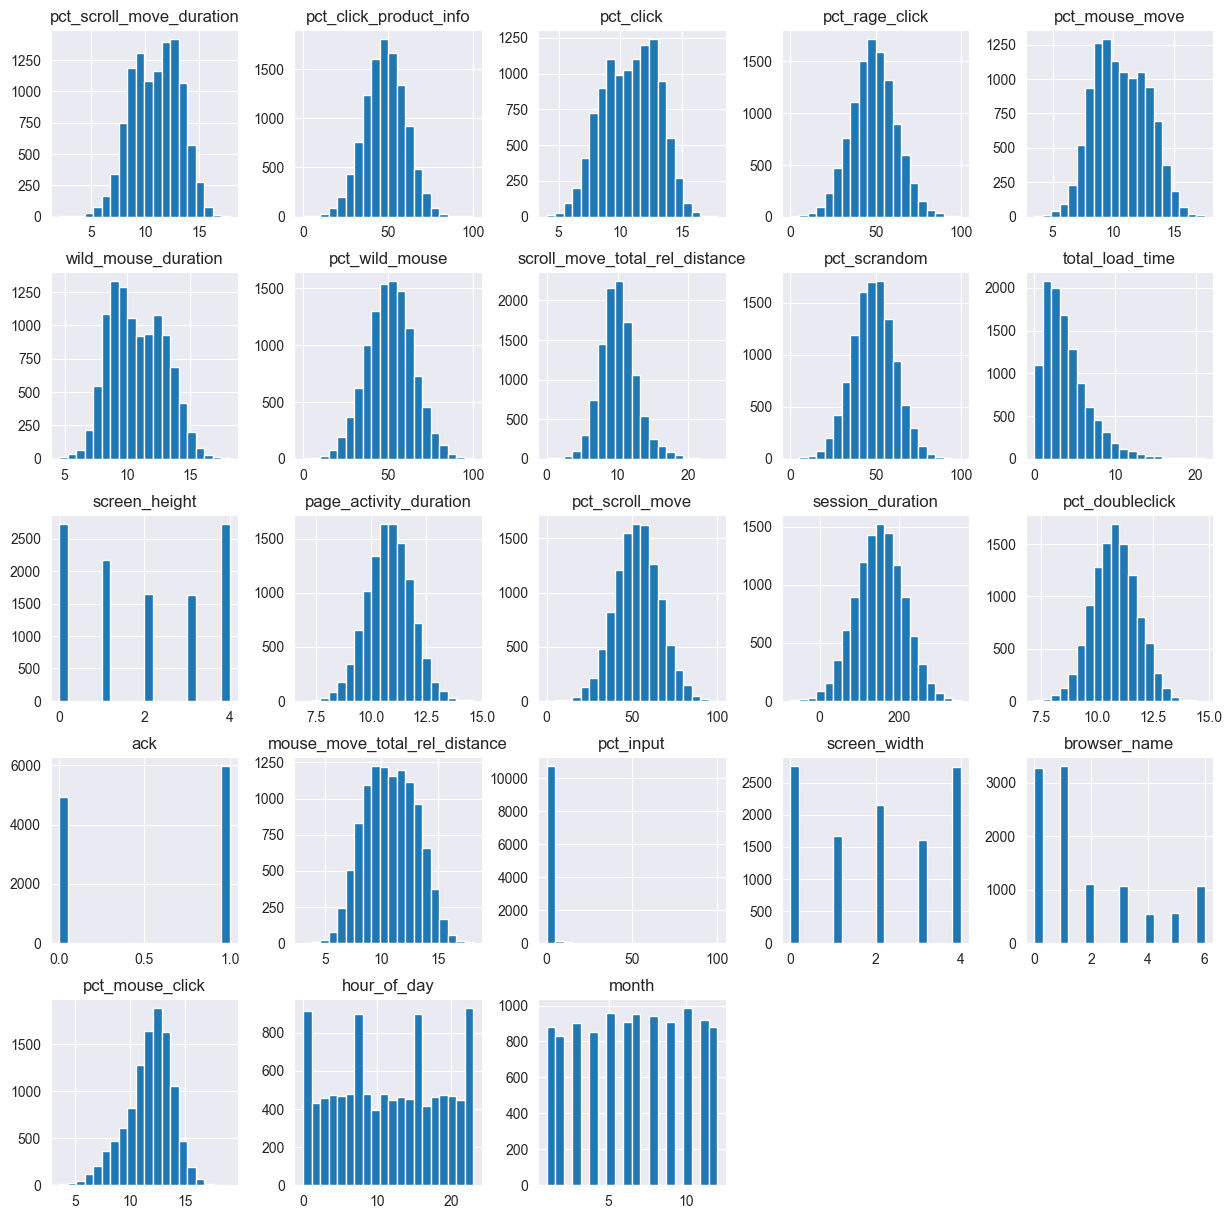

In [78]:
sessions.hist(bins=20, figsize=(15, 15))
plt.show()

### Prvotné odstránenie hodnôt na základe pozorovania
Z prvej fázy vieme, že dataset obsahuje sessions s negatívnym trvaním, a preto si ich vymažeme.

In [79]:
def remove_negative_session_duration(dataframe):
    dataframe = dataframe[dataframe['session_duration'] >= 0]
    return dataframe

sessions = remove_negative_session_duration(sessions)

### Druhotné detekovanie vychýlených hodnôt

In [80]:
outlier_columns = ['pct_scroll_move_duration', 'pct_click_product_info', 'pct_click', 'pct_rage_click', 'pct_mouse_move', 'wild_mouse_duration', 'pct_wild_mouse', 'scroll_move_total_rel_distance', 'pct_scrandom', 'total_load_time', 'page_activity_duration', 'pct_scroll_move', 'session_duration', 'pct_doubleclick', 'mouse_move_total_rel_distance', 'pct_input', 'pct_mouse_click']

def find_outliers(data, outliers_count):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count[column] = len(data[(data < lower_bound) | (data > upper_bound)])

former_outlier_column_count = {}
for column in outlier_columns:
    find_outliers(sessions[column], former_outlier_column_count)

sorted_columns = sorted(former_outlier_column_count, key=former_outlier_column_count.get, reverse=True)
outliers1, outliers2 = sorted_columns[:len(sorted_columns)//2], sorted_columns[len(sorted_columns)//2:]
former_outlier_column_count

{'pct_scroll_move_duration': 6,
 'pct_click_product_info': 66,
 'pct_click': 1,
 'pct_rage_click': 90,
 'pct_mouse_move': 3,
 'wild_mouse_duration': 5,
 'pct_wild_mouse': 58,
 'scroll_move_total_rel_distance': 289,
 'pct_scrandom': 101,
 'total_load_time': 365,
 'page_activity_duration': 76,
 'pct_scroll_move': 66,
 'session_duration': 30,
 'pct_doubleclick': 79,
 'mouse_move_total_rel_distance': 8,
 'pct_input': 1470,
 'pct_mouse_click': 211}

### Odstránenie vychýlených hodnôt na základe štandardnej deviácie
Na prvú časť, ktorá obsahuje vysoký počet vychýlených hodnôt sme sa rozhodli aplikovať odstránenie na základe štandardnej deviácie.

In [81]:
def remove_outliers_derivation(dataframe, column_name):
    dataframe_mean, dataframe_std = np.mean(dataframe[column_name]), np.std(dataframe[column_name])
    low = dataframe_mean - dataframe_std * 3
    high = dataframe_mean + dataframe_std * 3
    cleaned_dataframe = dataframe.loc[(dataframe[column_name] > low) & (dataframe[column_name] < high)]

    return cleaned_dataframe

for column in outliers1:
    sessions = remove_outliers_derivation(sessions, column)

### Odstránenie hraničných hodnôt na medzikvartilového rozptylu
Vychýlené hodnoty druhej časti je možné jednoducho dropnúť na základ IQR metódy

In [82]:
def remove_outliers_iqr(dataframe, column_name, threshold=1.5):
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1

    outliers = (dataframe[column_name] < (Q1 - threshold * IQR)) | (dataframe[column_name] > (Q3 + threshold * IQR))
    cleaned_dataframe = dataframe.loc[~outliers]

    return cleaned_dataframe

for column in outliers2:
    sessions = remove_outliers_iqr(sessions, column)

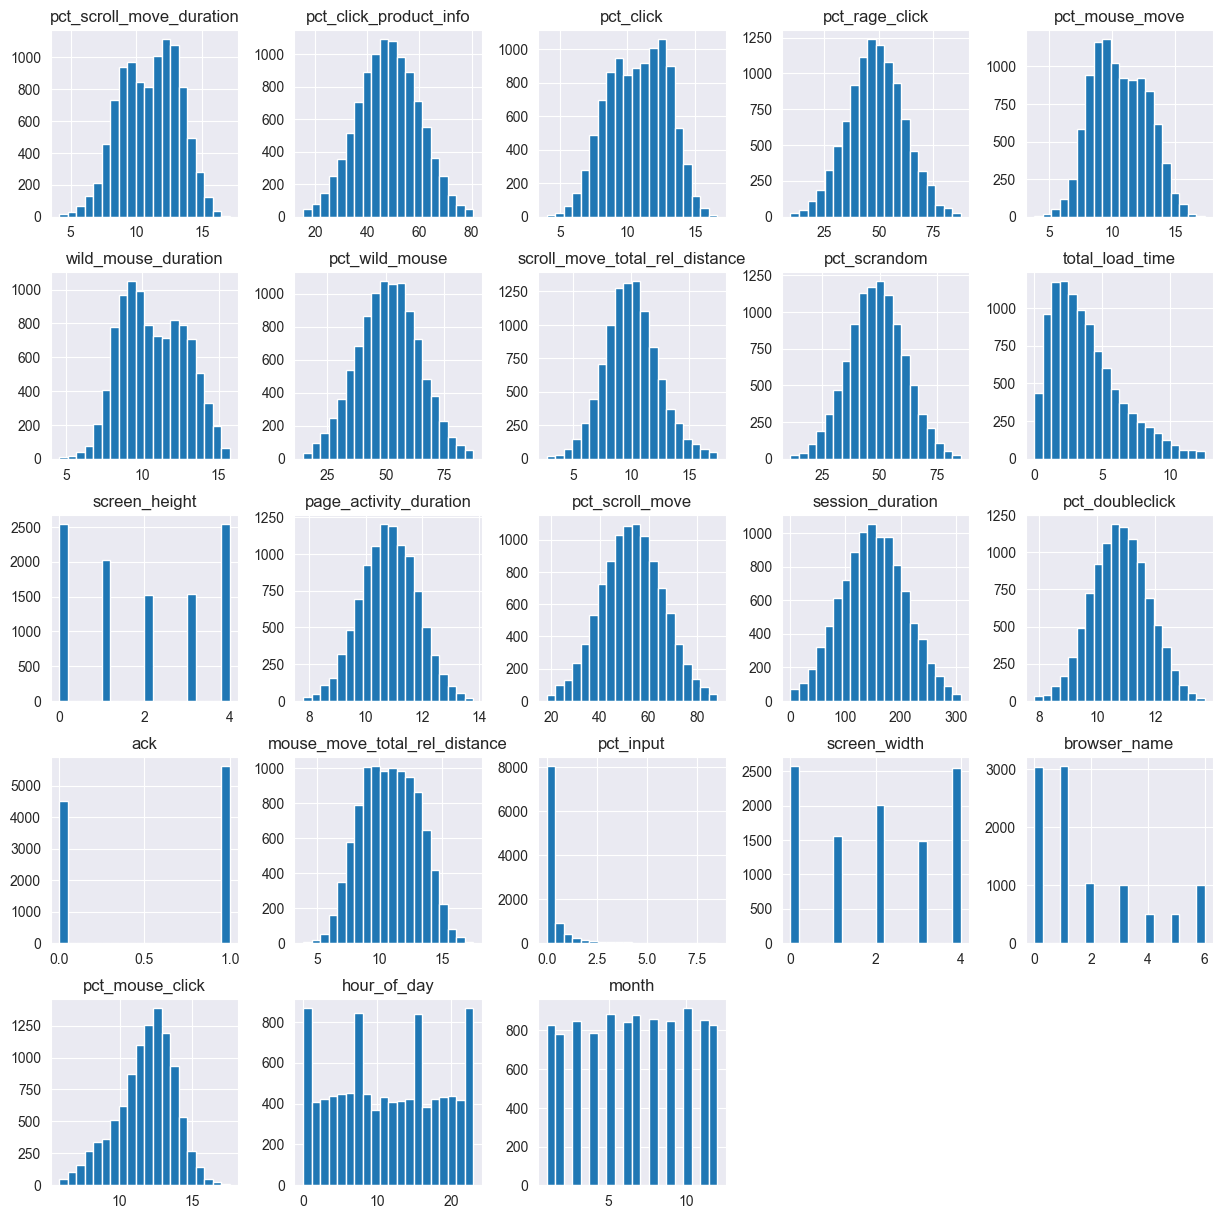

In [83]:
sessions.hist(bins=20, figsize=(15, 15))
plt.show()

### Počet vychýlených hodnôt sa nám podstatne znížil

In [84]:
outlier_column_count = {}
for column in outlier_columns:
    find_outliers(sessions[column], outlier_column_count)
outlier_column_count

{'pct_scroll_move_duration': 0,
 'pct_click_product_info': 5,
 'pct_click': 0,
 'pct_rage_click': 56,
 'pct_mouse_move': 0,
 'wild_mouse_duration': 0,
 'pct_wild_mouse': 4,
 'scroll_move_total_rel_distance': 165,
 'pct_scrandom': 59,
 'total_load_time': 224,
 'page_activity_duration': 37,
 'pct_scroll_move': 2,
 'session_duration': 0,
 'pct_doubleclick': 52,
 'mouse_move_total_rel_distance': 0,
 'pct_input': 1326,
 'pct_mouse_click': 119}

### Kontrola pomocou heat mapy
### Pred odstranením vychýlených hodnôt

<Axes: >

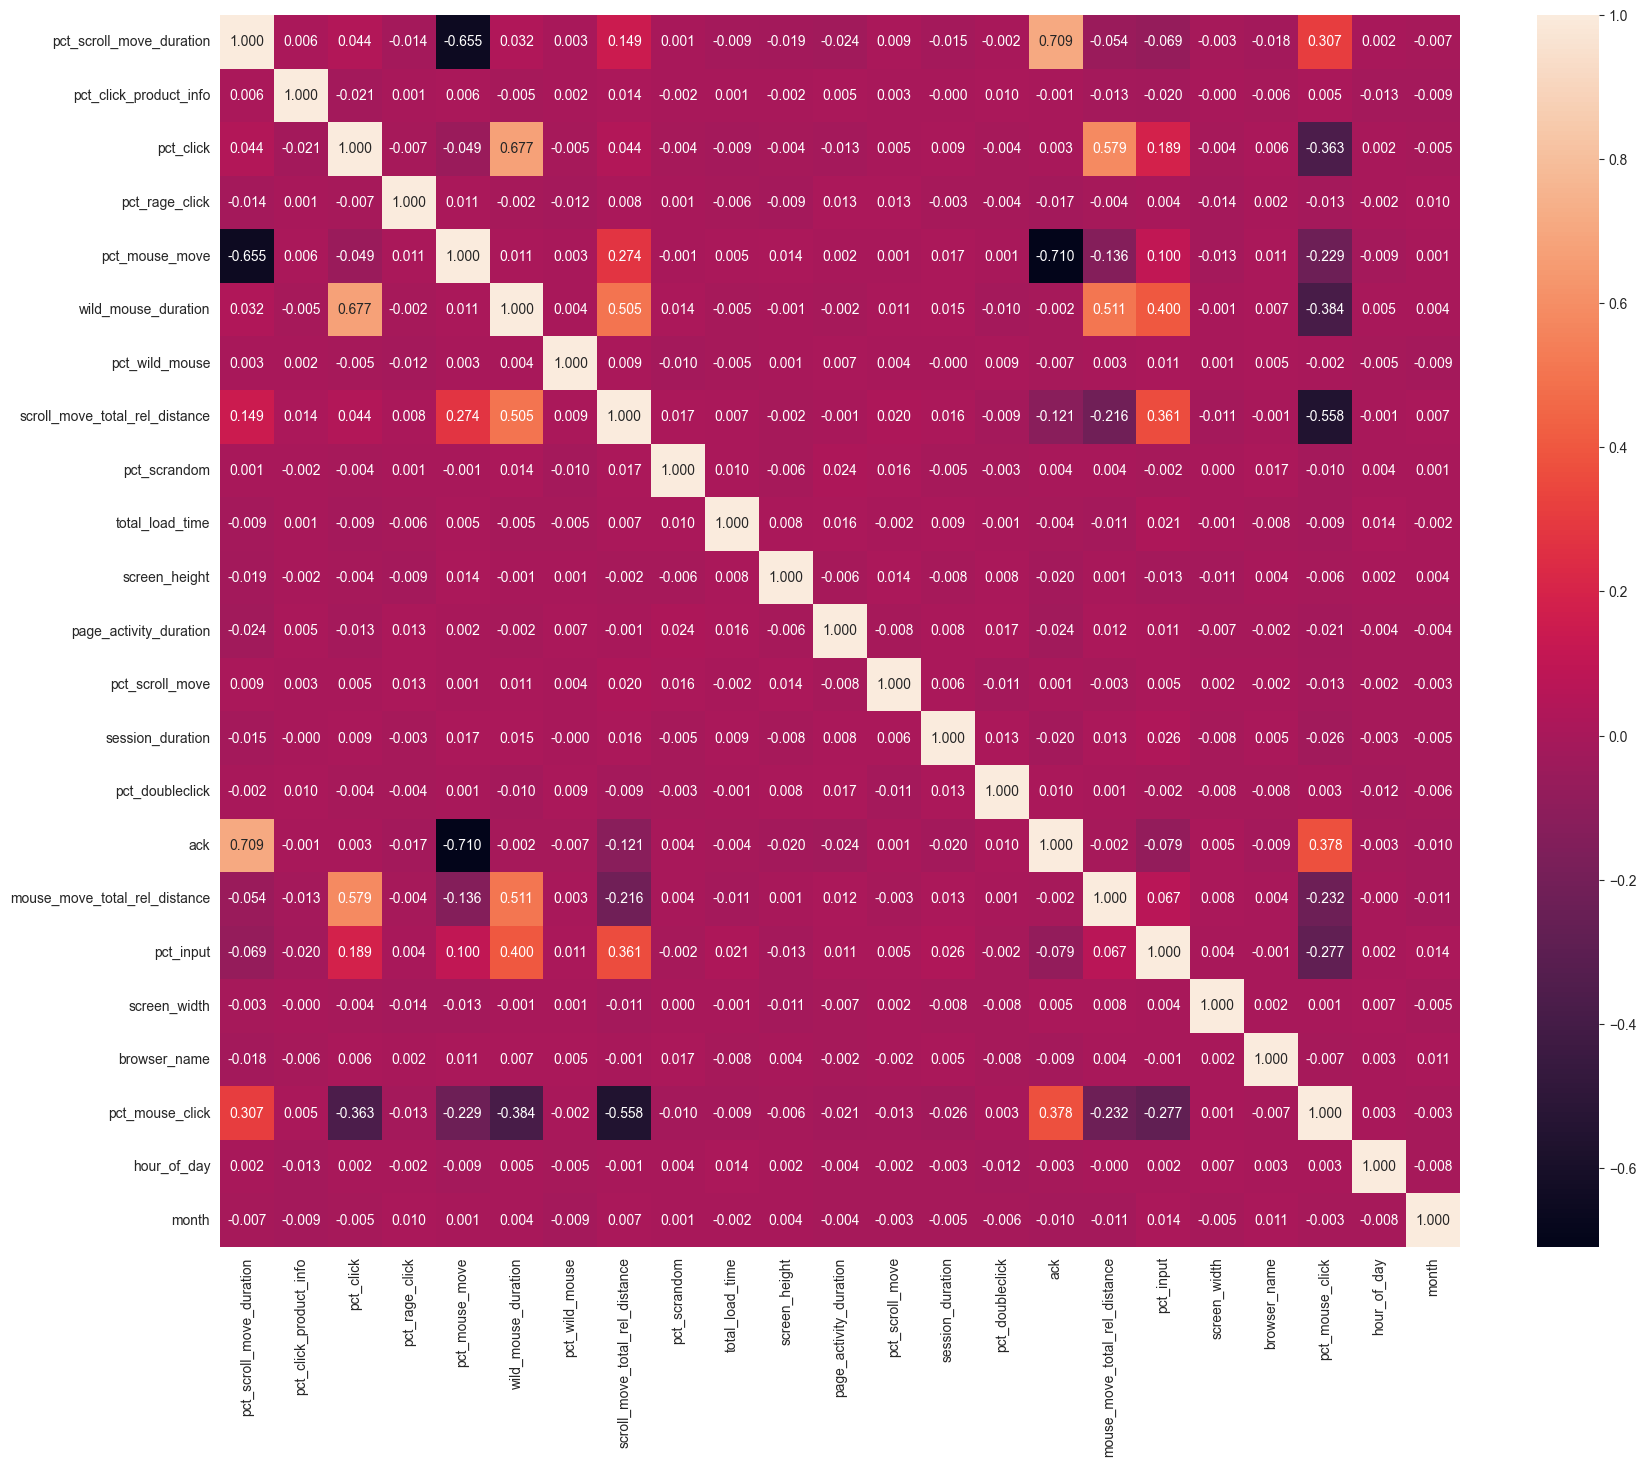

In [85]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(original_sessions.corr(),ax=ax, annot =True, fmt = ".3f")

### Po odstránení vychýlených hodnôt

<Axes: >

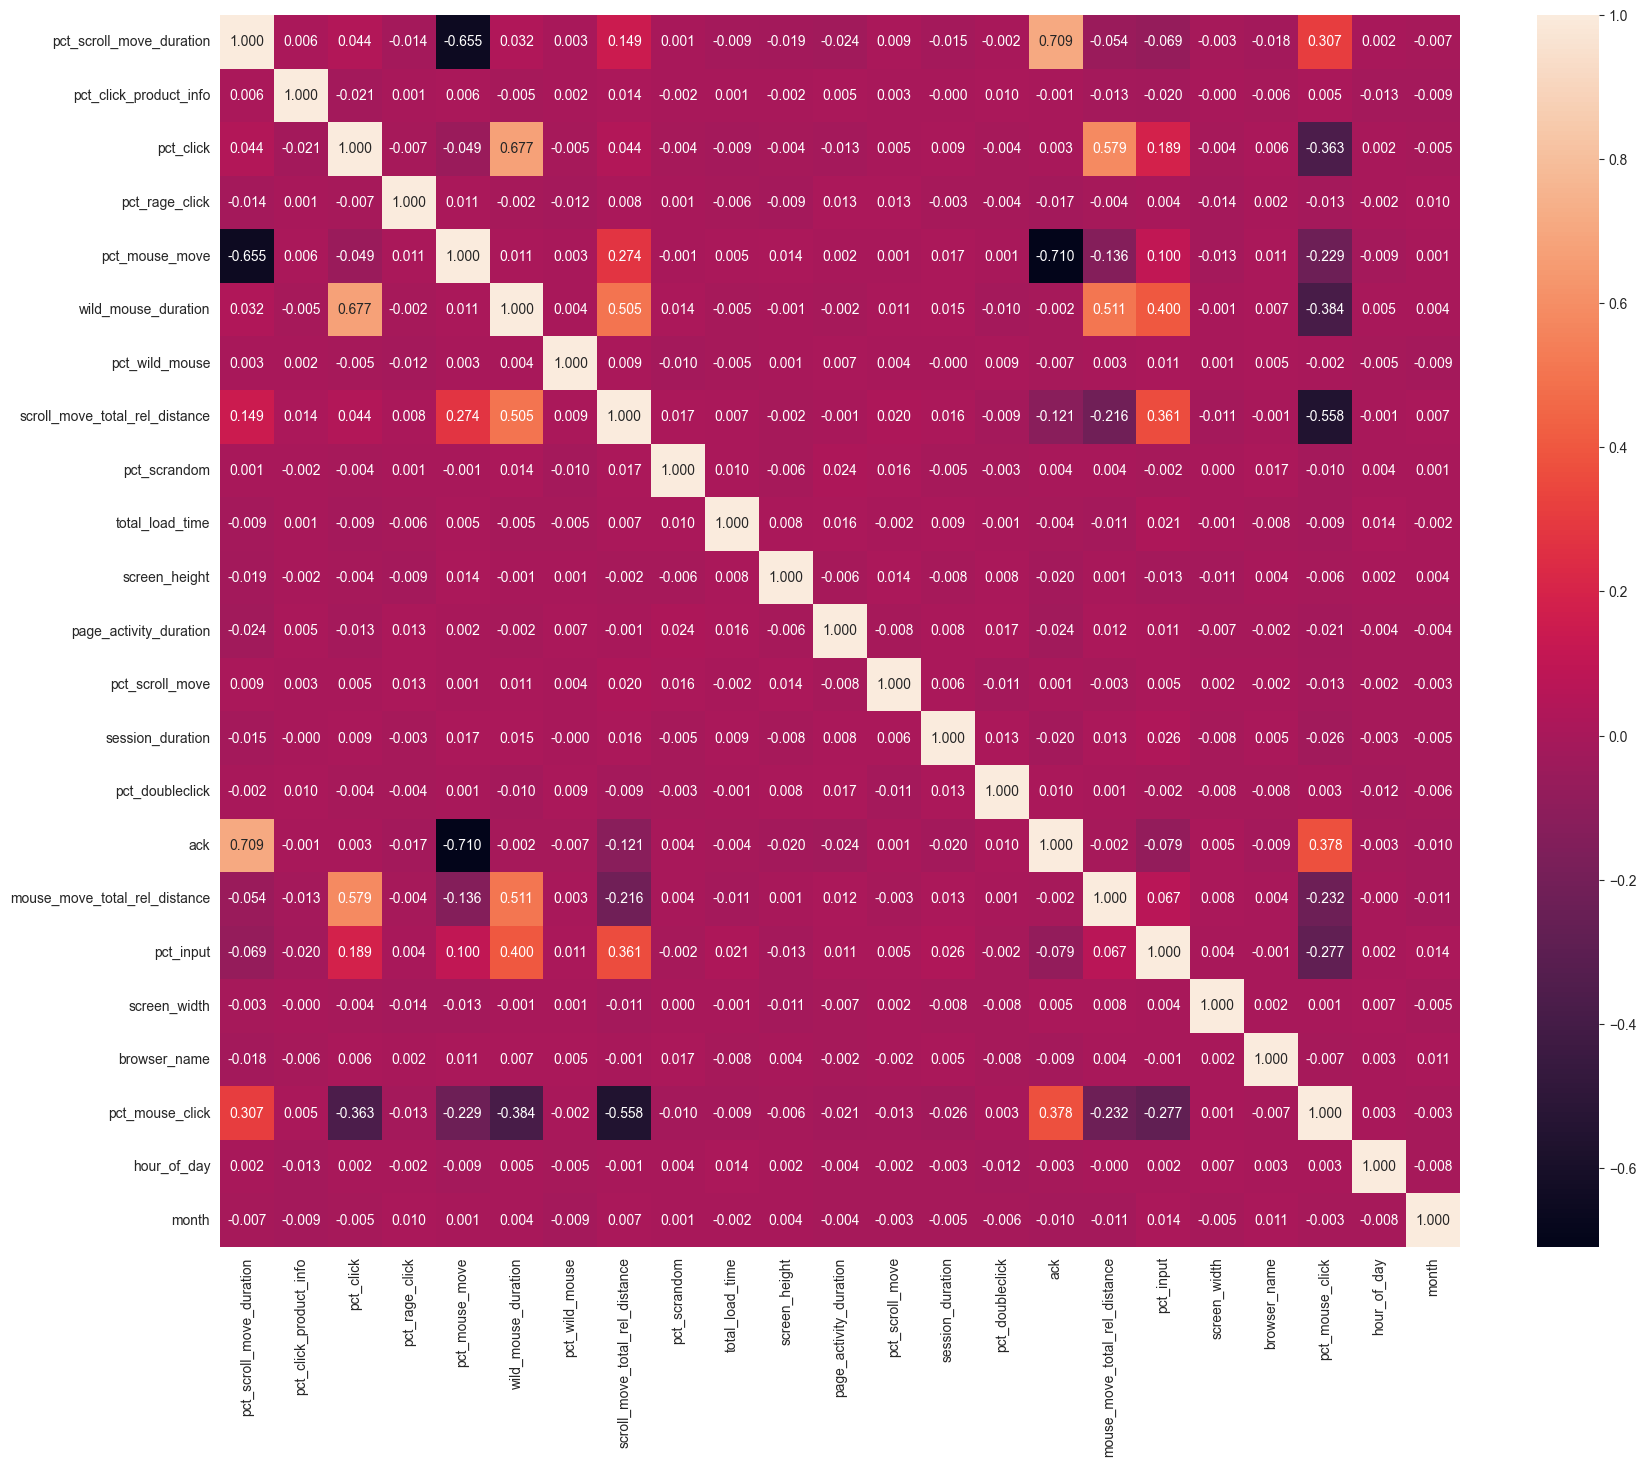

In [86]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(original_sessions.corr(),ax=ax, annot =True, fmt = ".3f")

## Realizácia predspracovania dát
### Rozdelenie na trénovaciu a testovaciu množinu
Keďže naše dáta už boli očistené a sú všetky v rovnakom formáte, `float64`, je možné si ich rozdeliť na trénovaciu a testovaciu množinu. Celkový počet dát je nízky, a preto sme sa zhodli, že rozdelenie 90:10 bude najoptimálnejšie, keďže chceme, aby náš model bol čo najefektívnejší. Taktiež si vytvoríme kópiu pôvodných trénovacích dát, aby sme vedeli porovnať ako sa naše dáta zmenili pred a po transformácií.

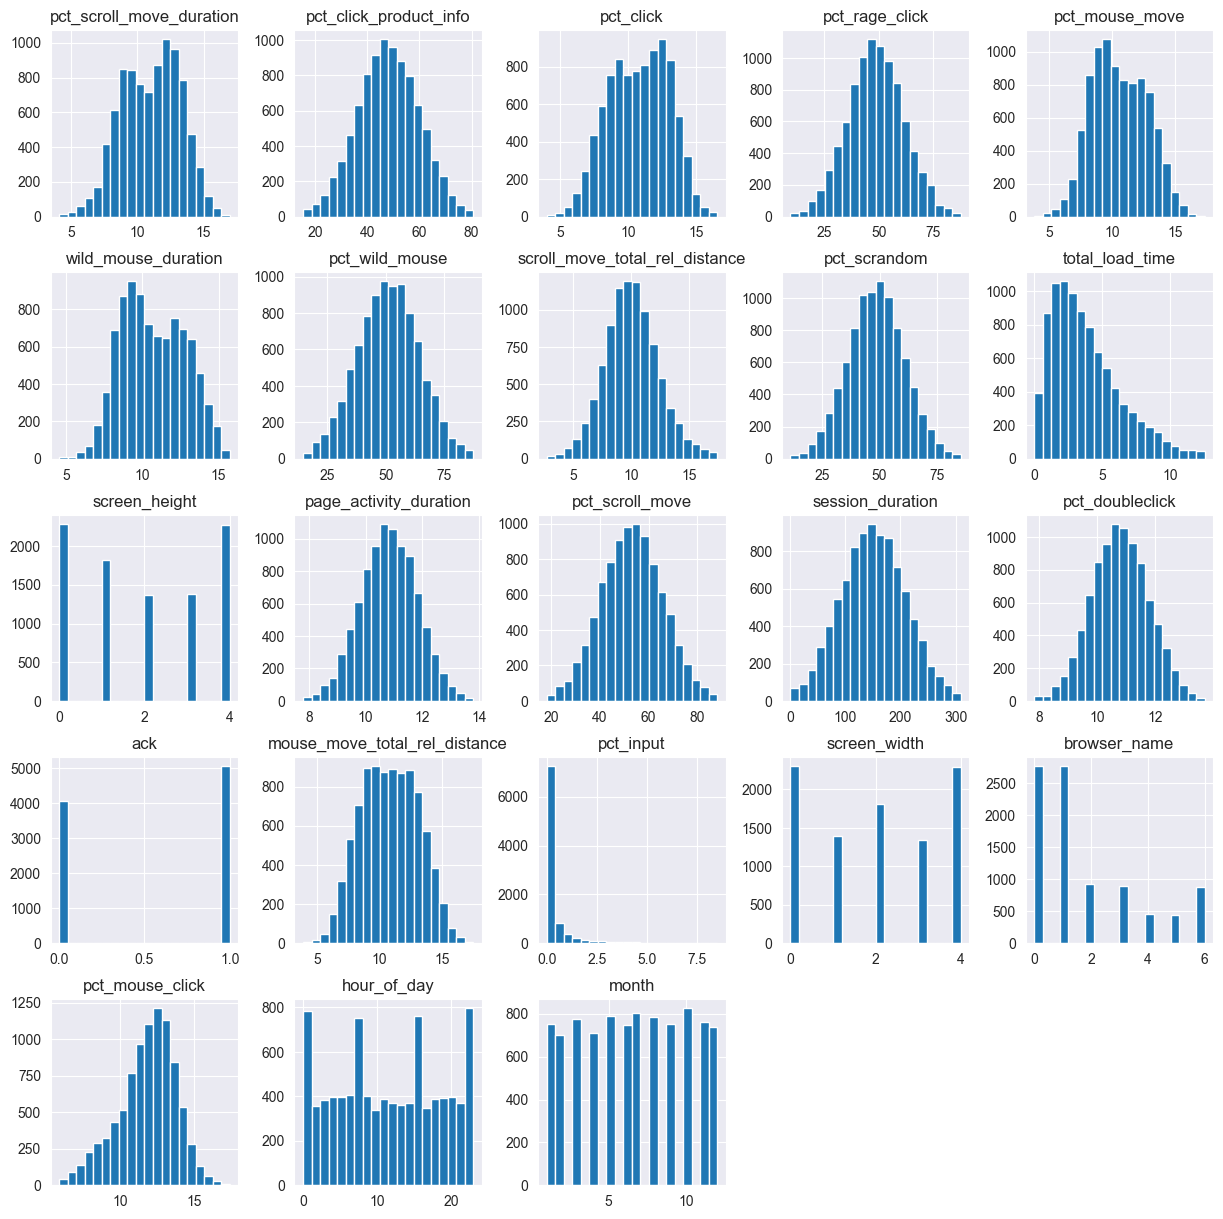

In [87]:
train_data, test_data= train_test_split(sessions, test_size=0.1, random_state=1)
original_train_data = train_data.copy()
train_data.hist(bins=20, figsize=(15, 15))
plt.show()

### Transformácia atribútov dát
Na trénovacom datasete použijeme transformácie a škálovanie na to, aby sme našemu modelu zjednodušili prácu s datasetom:
* Quantile Transformer
* Power Transformer
* Minmax Scaler
* Robust Scaler 
* Standard Scaler

Nazačiatku si zadefinujeme vizualizačnú funkciu, ktorá nám pomôže s porovnávaním pôvodnej formy trénovacieho datasetu s formou po transformácií.

In [88]:
def plot_histograms(data1, data2, column_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title("Before")
    ax1.hist(data1, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_xlabel(column_name)

    ax2.set_title("After")
    ax2.hist(data2, bins='auto', color='green', alpha=0.7, rwidth=0.85)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.set_xlabel(column_name)

    plt.tight_layout()
    plt.show()

### Quantile Transformer
Algoritmy strojového učenia dosahujú lepšie výsledky, keď sú atribúty distribuované podobne, ako normálne, Gaussovské rozdelenie. Vybrali sme atribúty, ktoré majú prominentný pozitívny sklon a rozhodli sme sa ich transformovať pomocou Quantile Transformer.

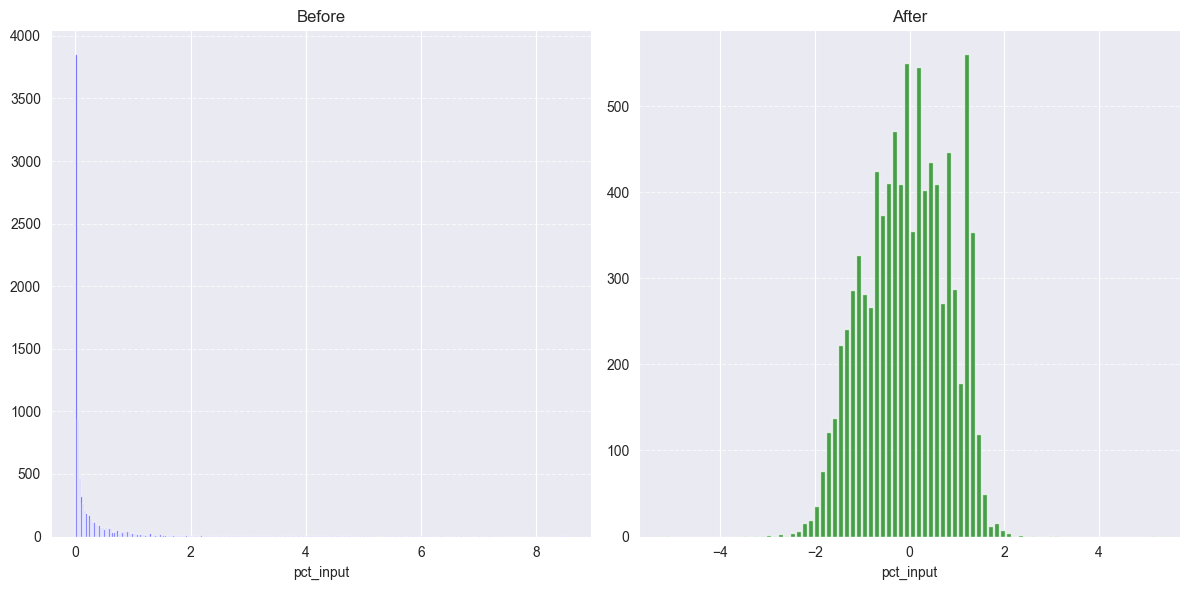

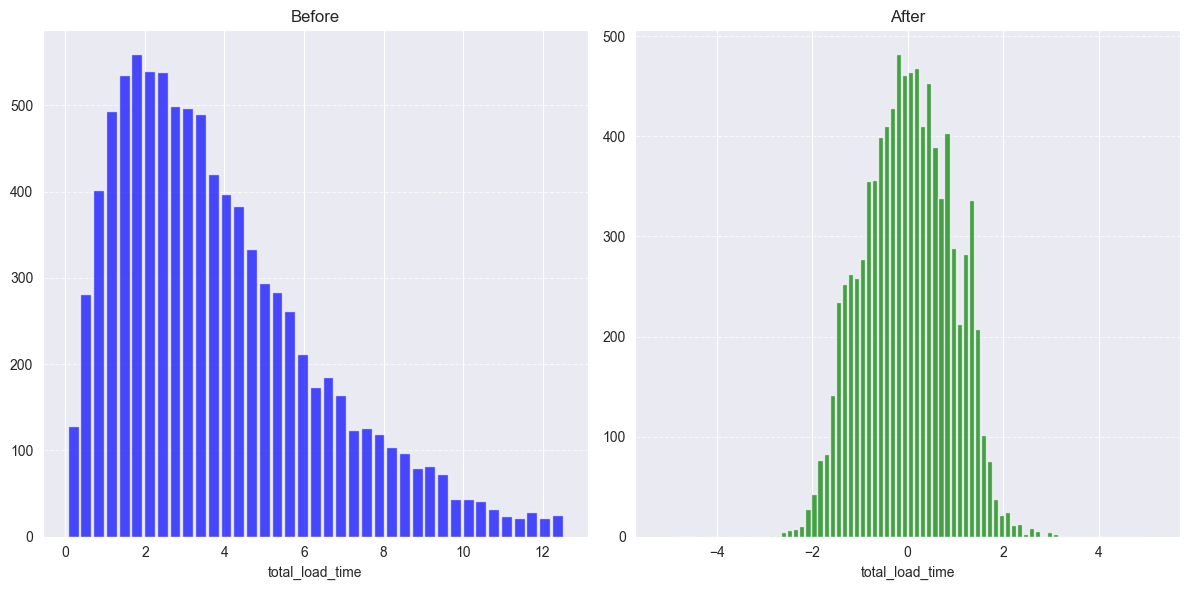

In [89]:
quantile = [
    "pct_input",
    "total_load_time"
]

def quantile_transformer(dataframe, column_name):
    qt = QuantileTransformer(output_distribution="normal", n_quantiles=10, random_state=42)
    dataframe[column_name] = qt.fit_transform(dataframe[[column_name]])
    return dataframe

for column in quantile:
    train_data = quantile_transformer(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

### Power Transformer
PowerTransformer sa obvykle používa, keď sú dáta skewed, sklonené a neobsahujú veľa vychýlených hodnôt, preto je potrebné ich identifikovať okometrickou metódou z histogramov. Po aplikovaní transformácie sa zmena vizualizuje.

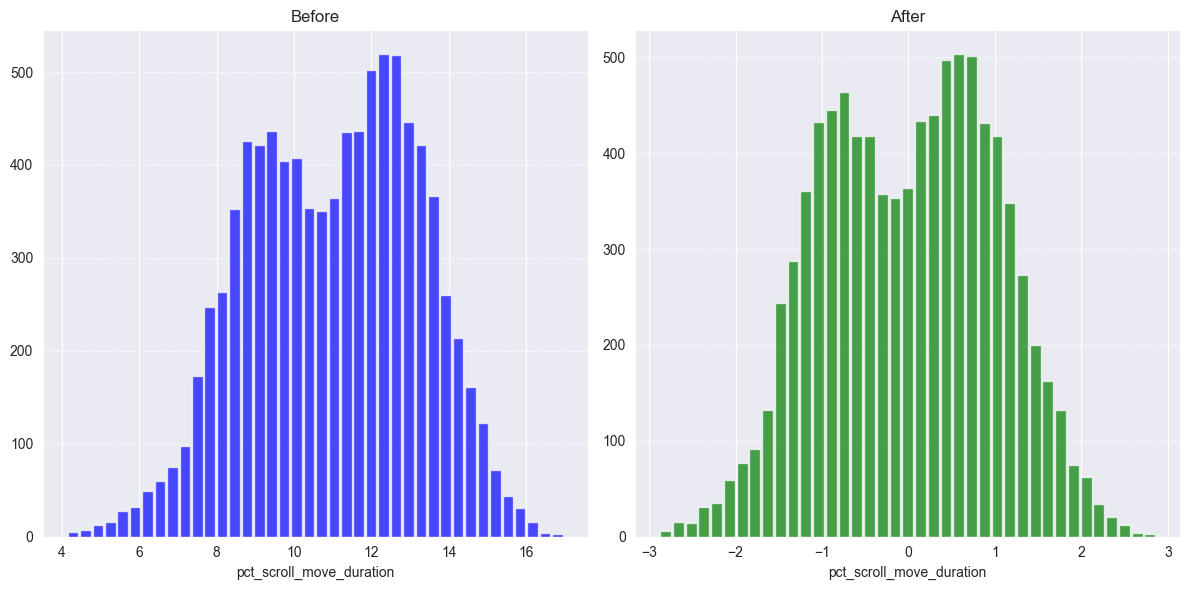

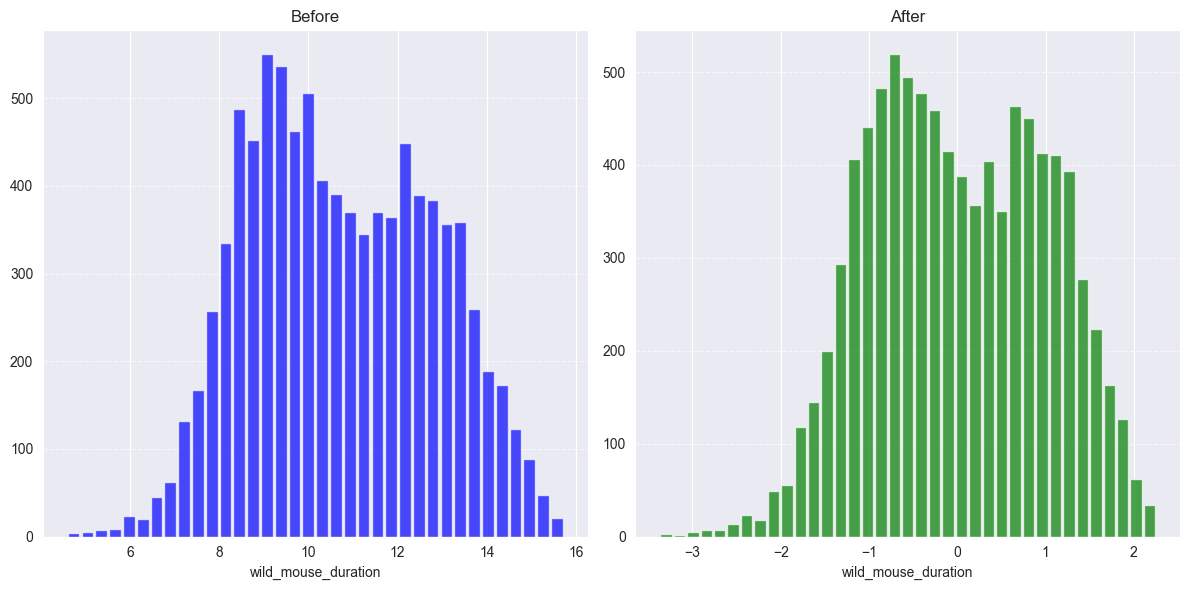

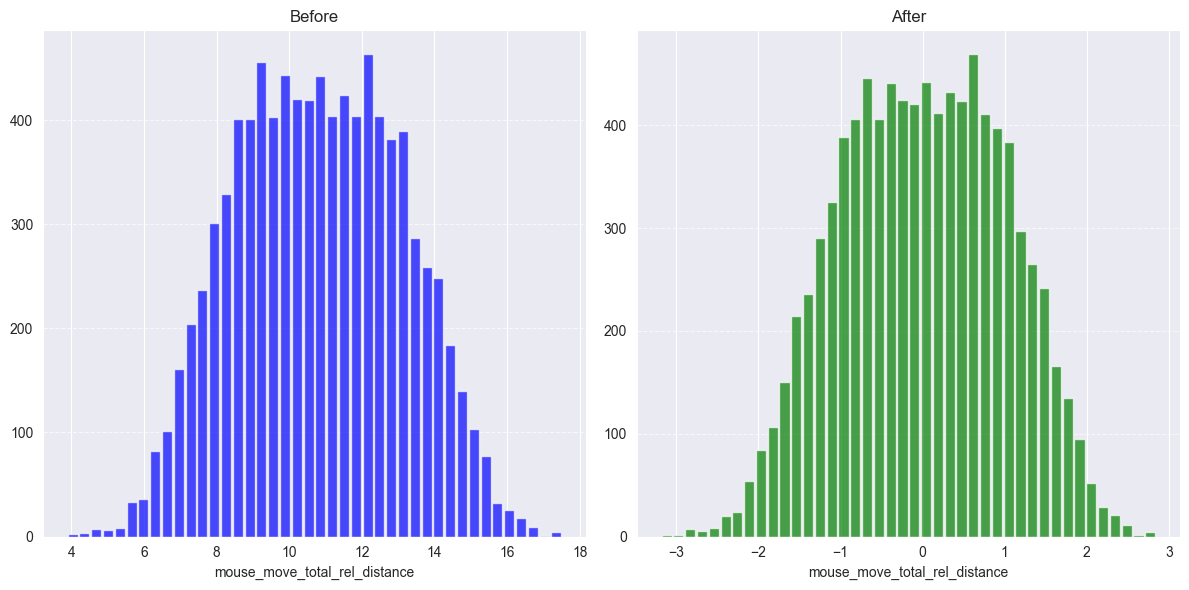

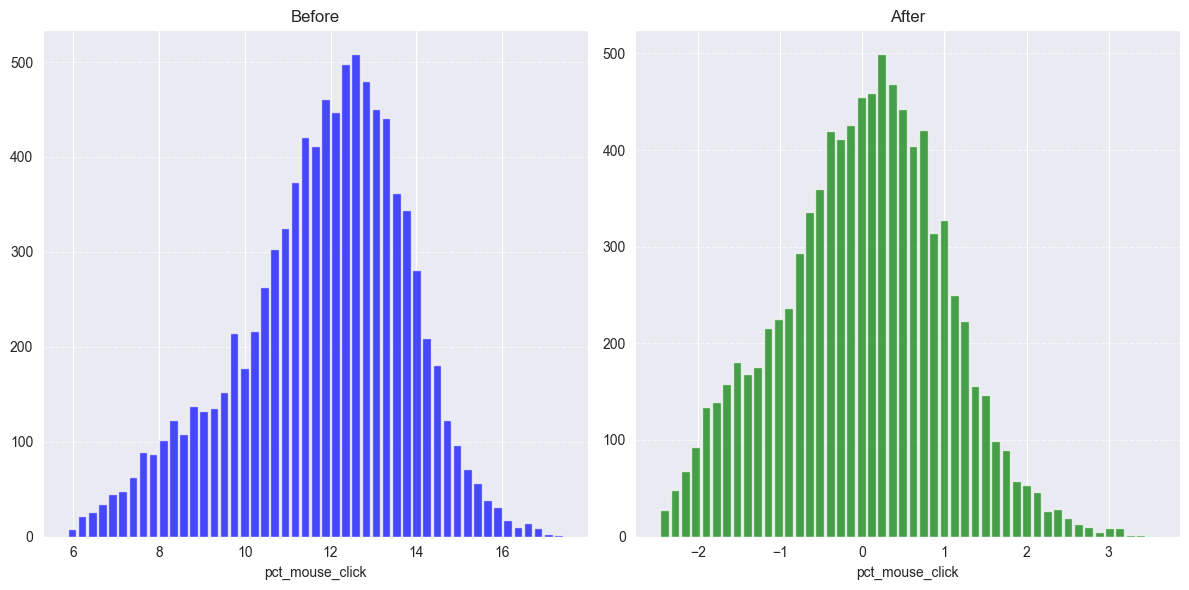

In [90]:
transformer = [
    "pct_scroll_move_duration",
    "wild_mouse_duration",
    "mouse_move_total_rel_distance",
    "pct_mouse_click"
]

def power_transformer(dataframe, column_name):
    dataframe[column_name] = PowerTransformer().fit_transform(dataframe[[column_name]])
    return dataframe 

for column in transformer:
    train_data = power_transformer(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

### MinMax Scaler 
MinMax Scalerom dáta vieme normalizovať do menšieho rozsahu. Táto technika však nie je efektívna pokiaľ atribút obsahuje veľa vychýlených hodnôt preto je potrebné vybrať atribúty, ktoré nadobúdajú veľkú škálu hodnôt a obsahujú nízky počet vychýlených hodnôt.

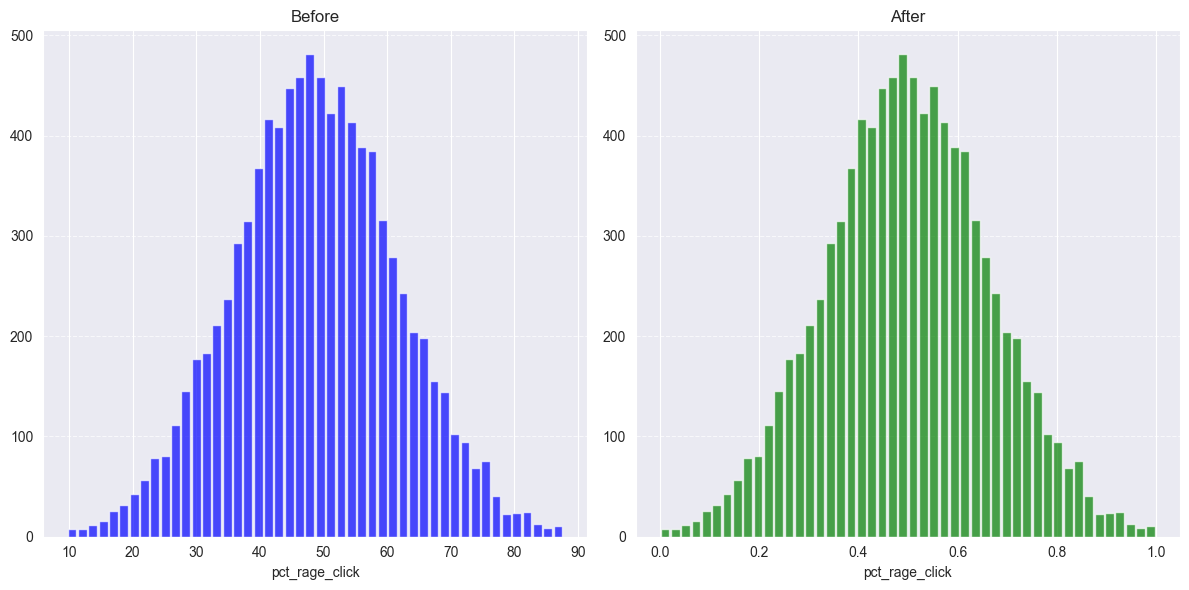

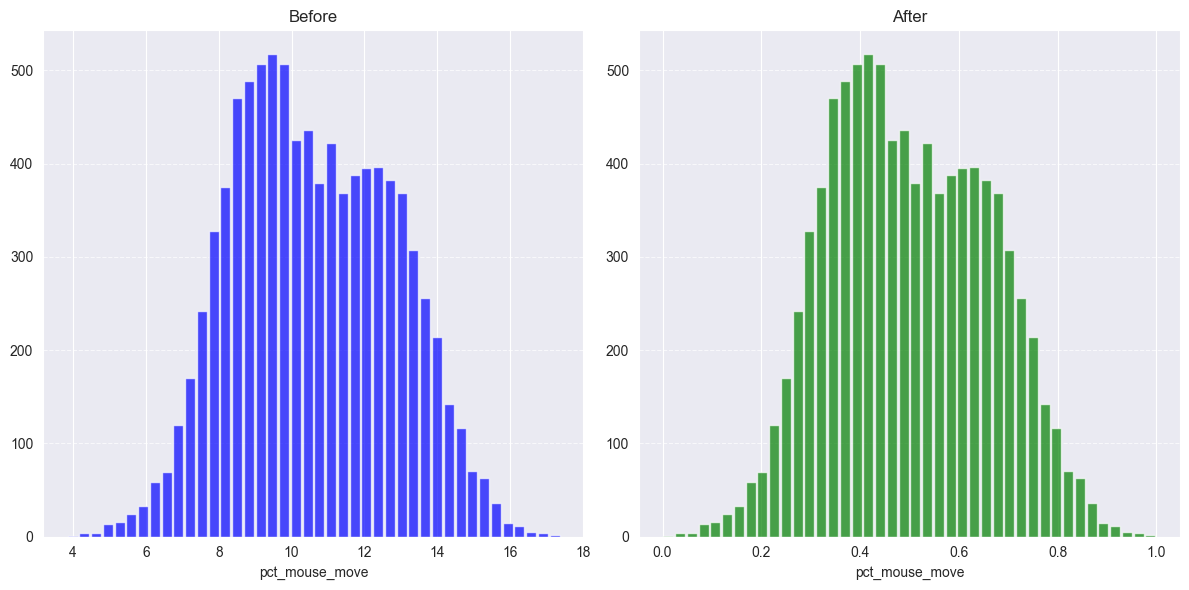

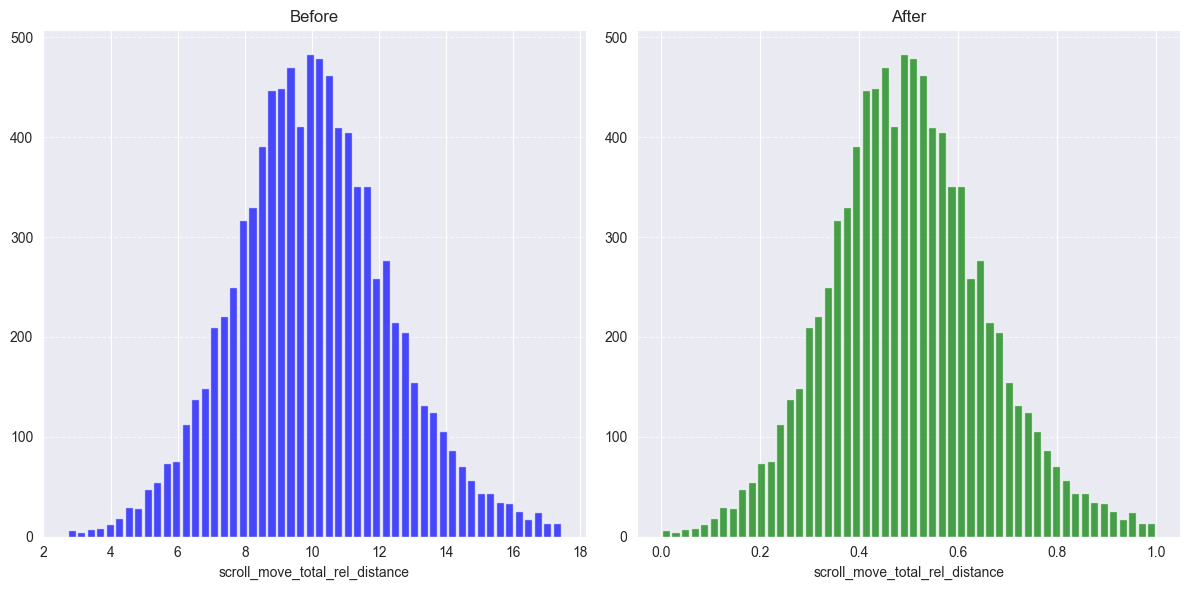

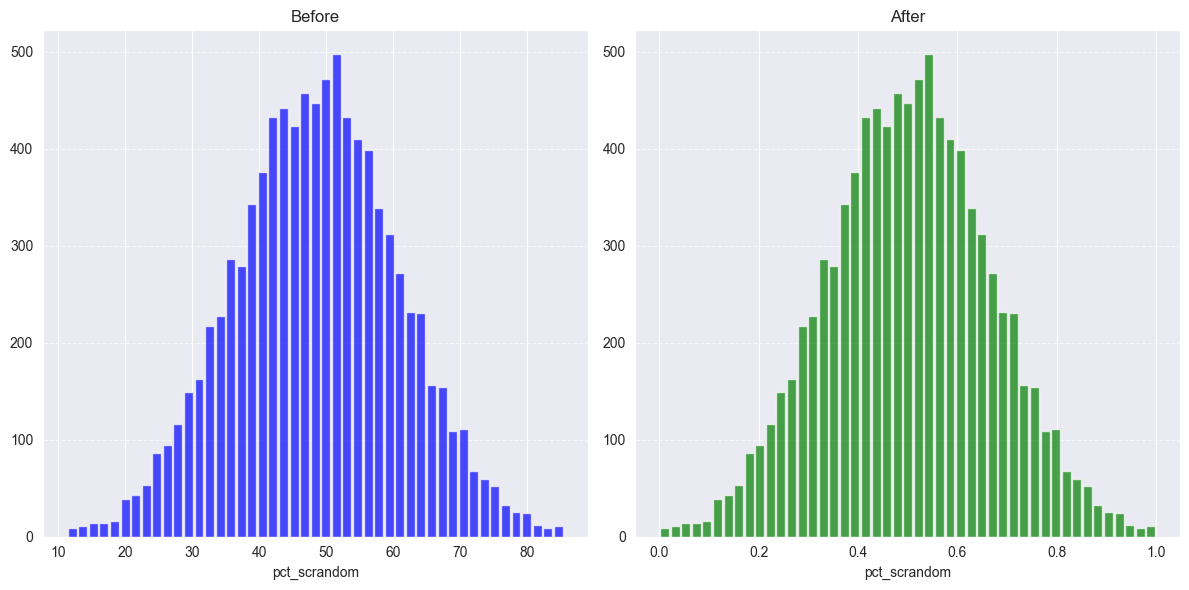

In [91]:
minmax = [
    "pct_rage_click",
    "pct_mouse_move",
    "scroll_move_total_rel_distance",
    "pct_scrandom"
]

def minmax_scaler(dataframe, column_name):
    dataframe[column_name] = MinMaxScaler().fit_transform(dataframe[[column_name]])
    return dataframe

for column in minmax:
    train_data = minmax_scaler(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

### Robust scaler
Toto škálovanie je užitočné predovšetkým pri práci s údajmi obsahujúcimi vychýlené hodnoty. RobustScaler sa s nimi vysporiada pomocou medzikvartilového rozsahu a mediánu. 

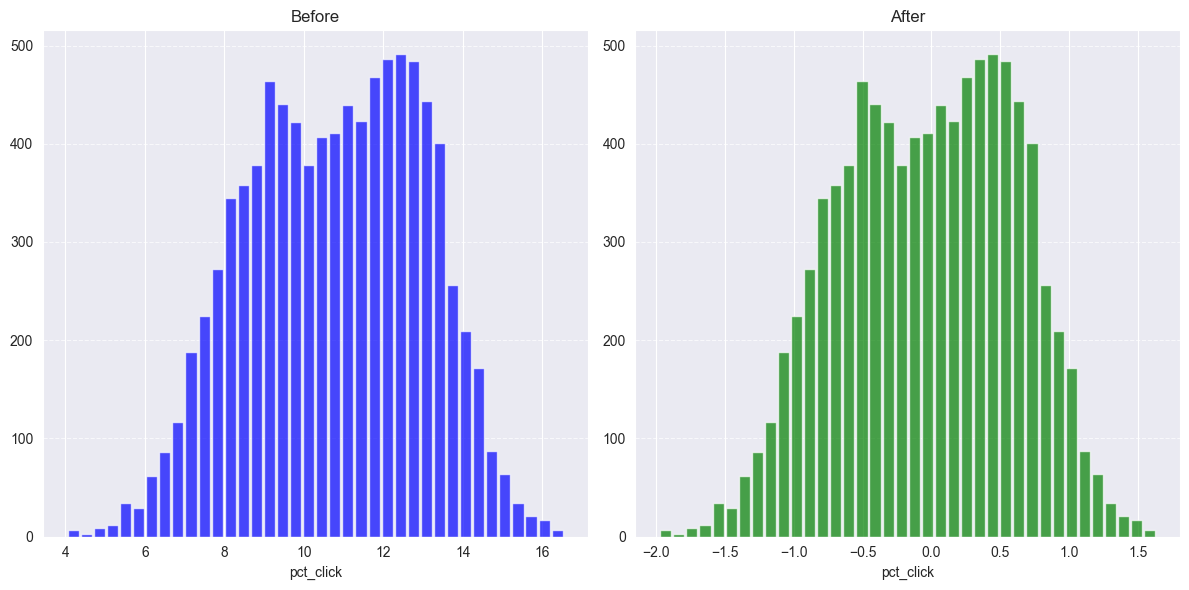

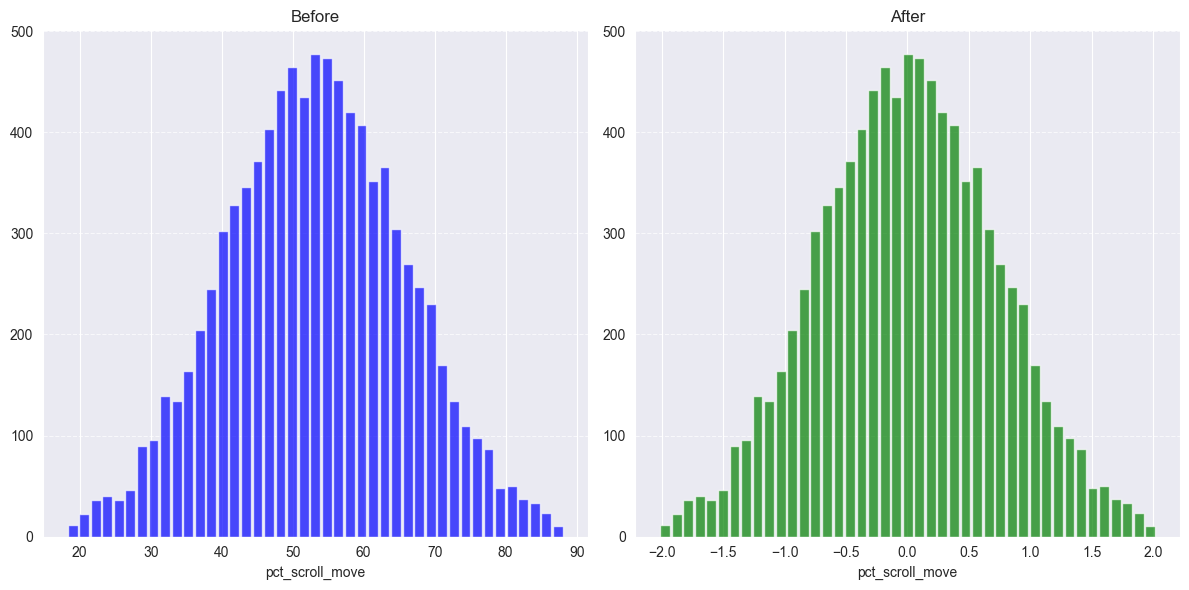

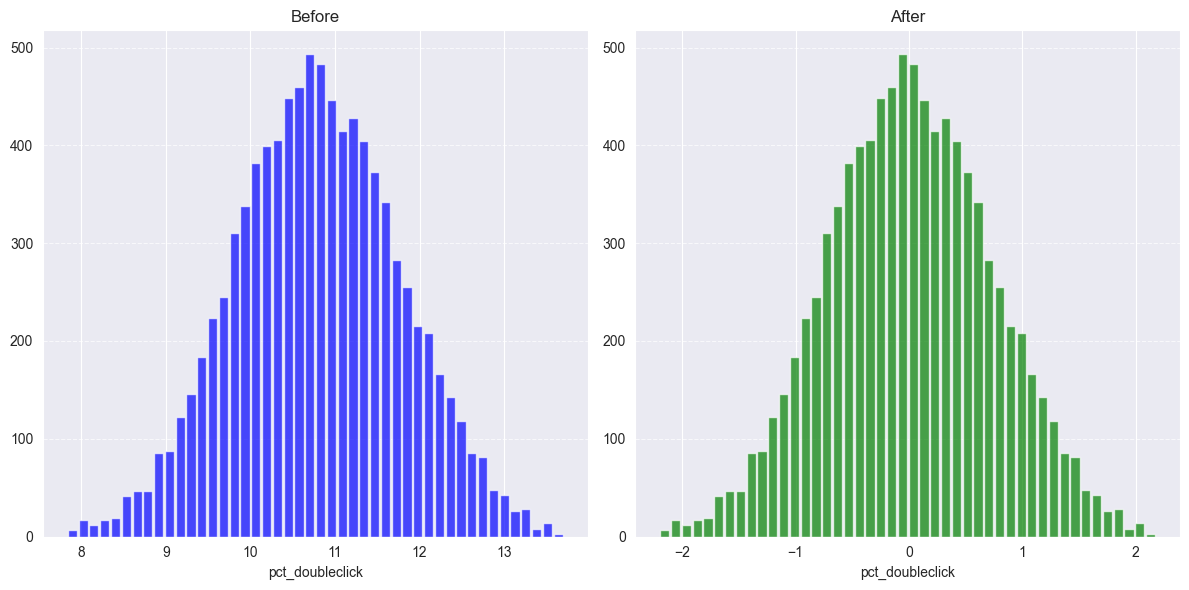

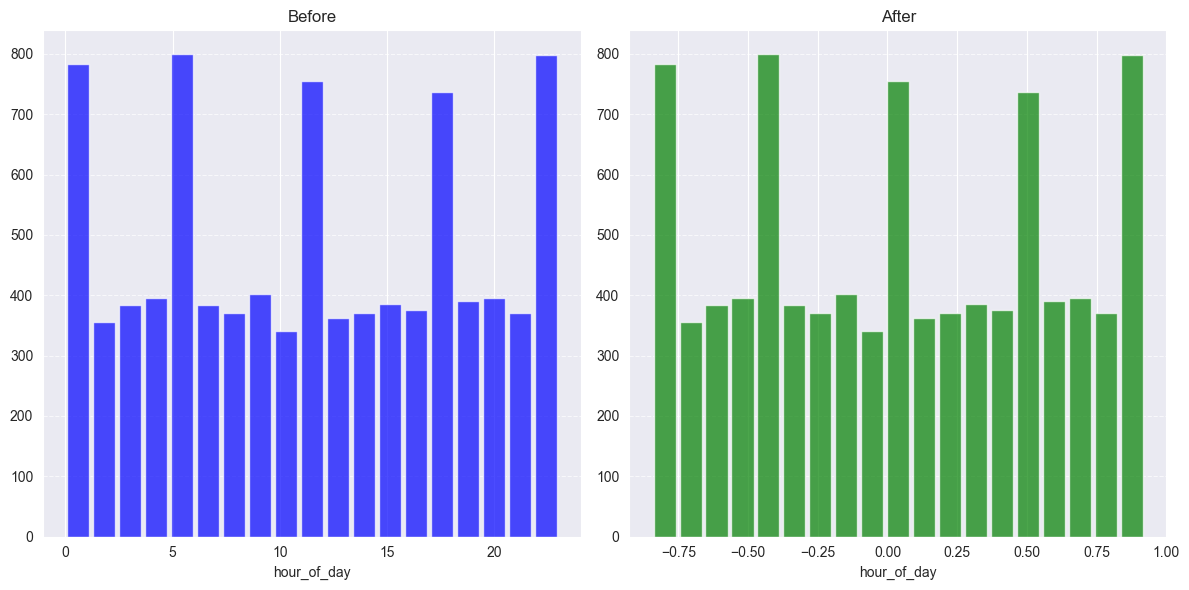

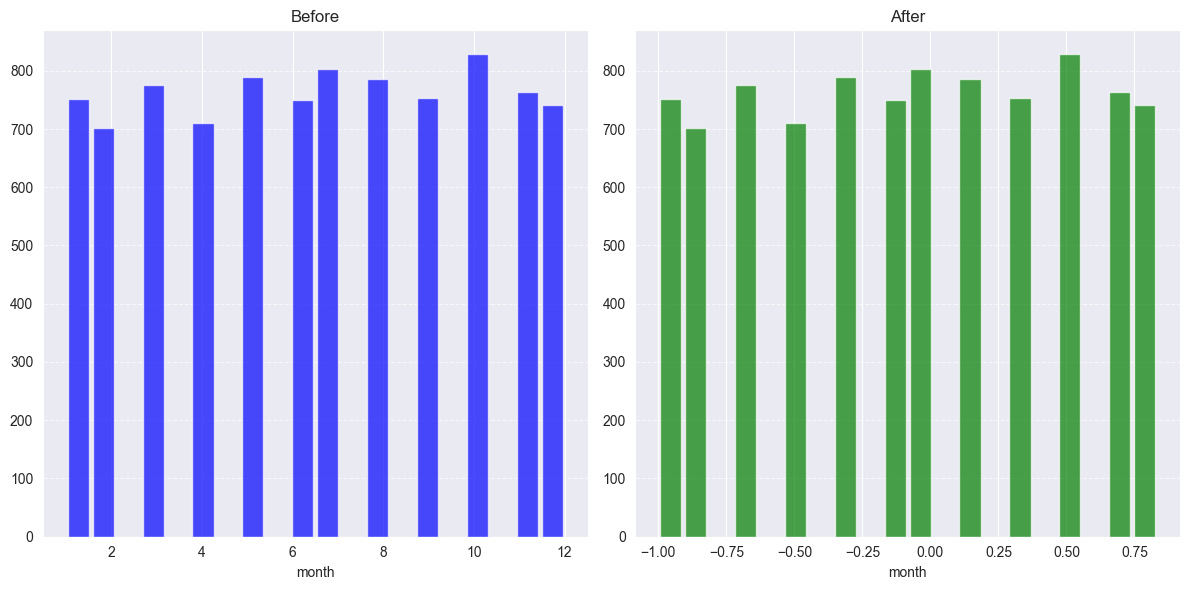

In [92]:
robust = [
    "pct_click",
    "pct_scroll_move",
    "pct_doubleclick",
    "hour_of_day",
    "month"
]

def robust_scaler(dataframe, column_name):
    dataframe[column_name] = RobustScaler().fit_transform(dataframe[[column_name]])
    return dataframe

for column in robust:
    train_data = robust_scaler(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

### Standard Scaler
Zvyšné dáta, ktoré sú veľmi podobné normálnemu rozdeleniu zoškálujeme pomocou standard scalera, aby sme zmenšili ich rozptyl. `Ack` a atribúty `screen_height`, `screen_width`, `browser_name` na ktoré sme aplikovali Label Encoding nie je potrebné škálovať ani transformovať.

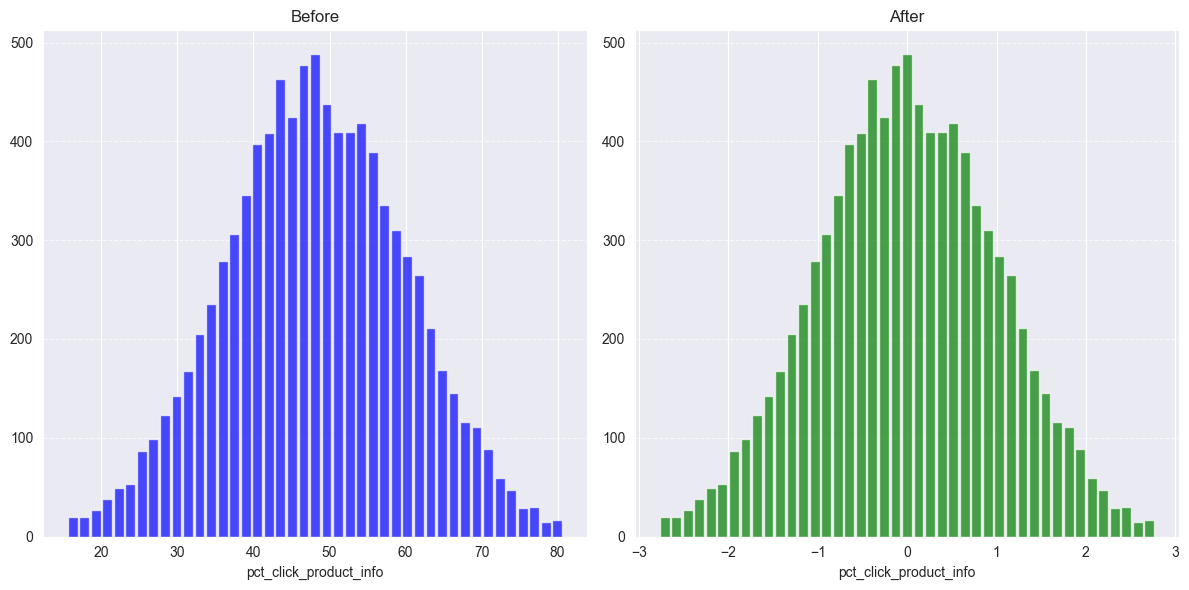

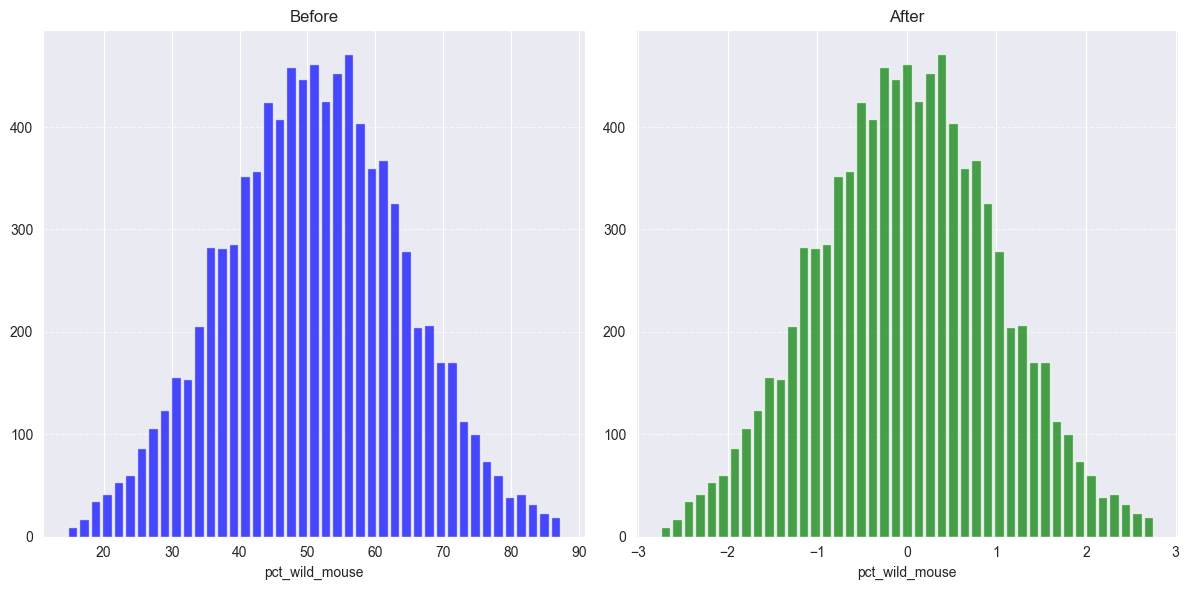

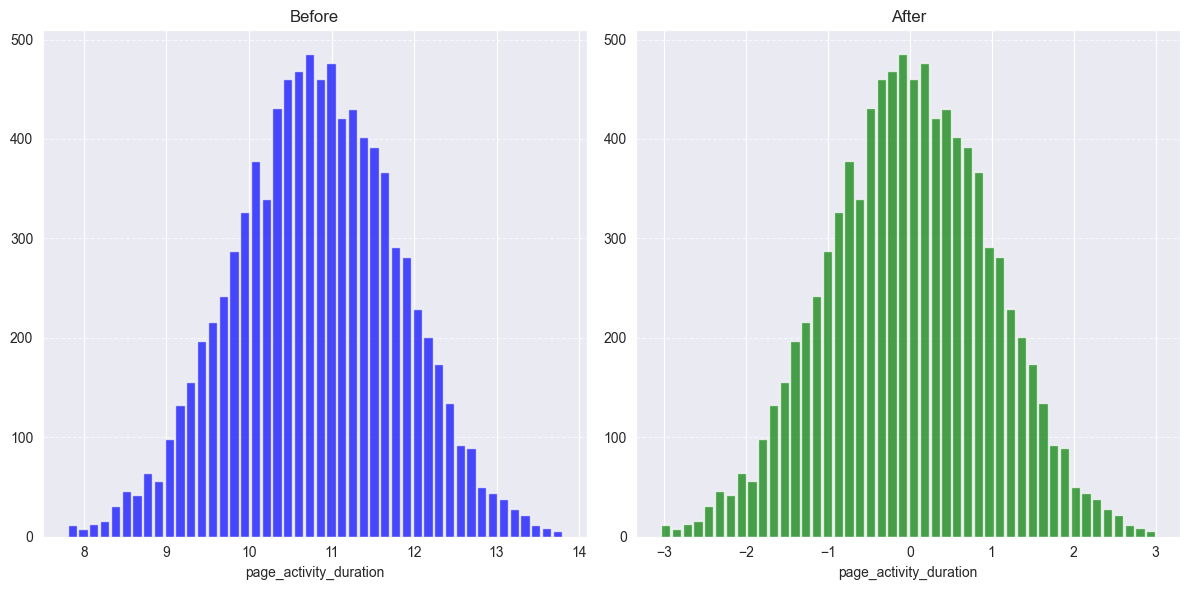

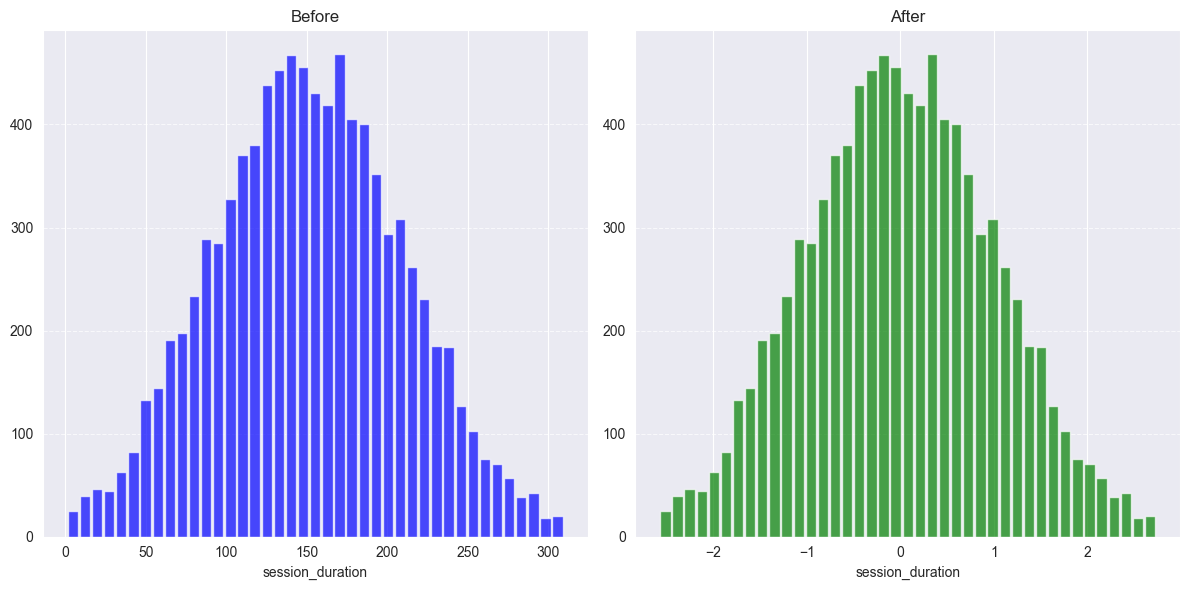

In [93]:
standard = [
    "pct_click_product_info",
    "pct_wild_mouse",
    "page_activity_duration",
    "session_duration"
]

def standard_scaler(dataframe, column_name):
    dataframe[column_name] = StandardScaler().fit_transform(dataframe[[column_name]])
    return dataframe

for column in standard:
    train_data = standard_scaler(train_data, column)
    plot_histograms(original_train_data[column], train_data[column], column)

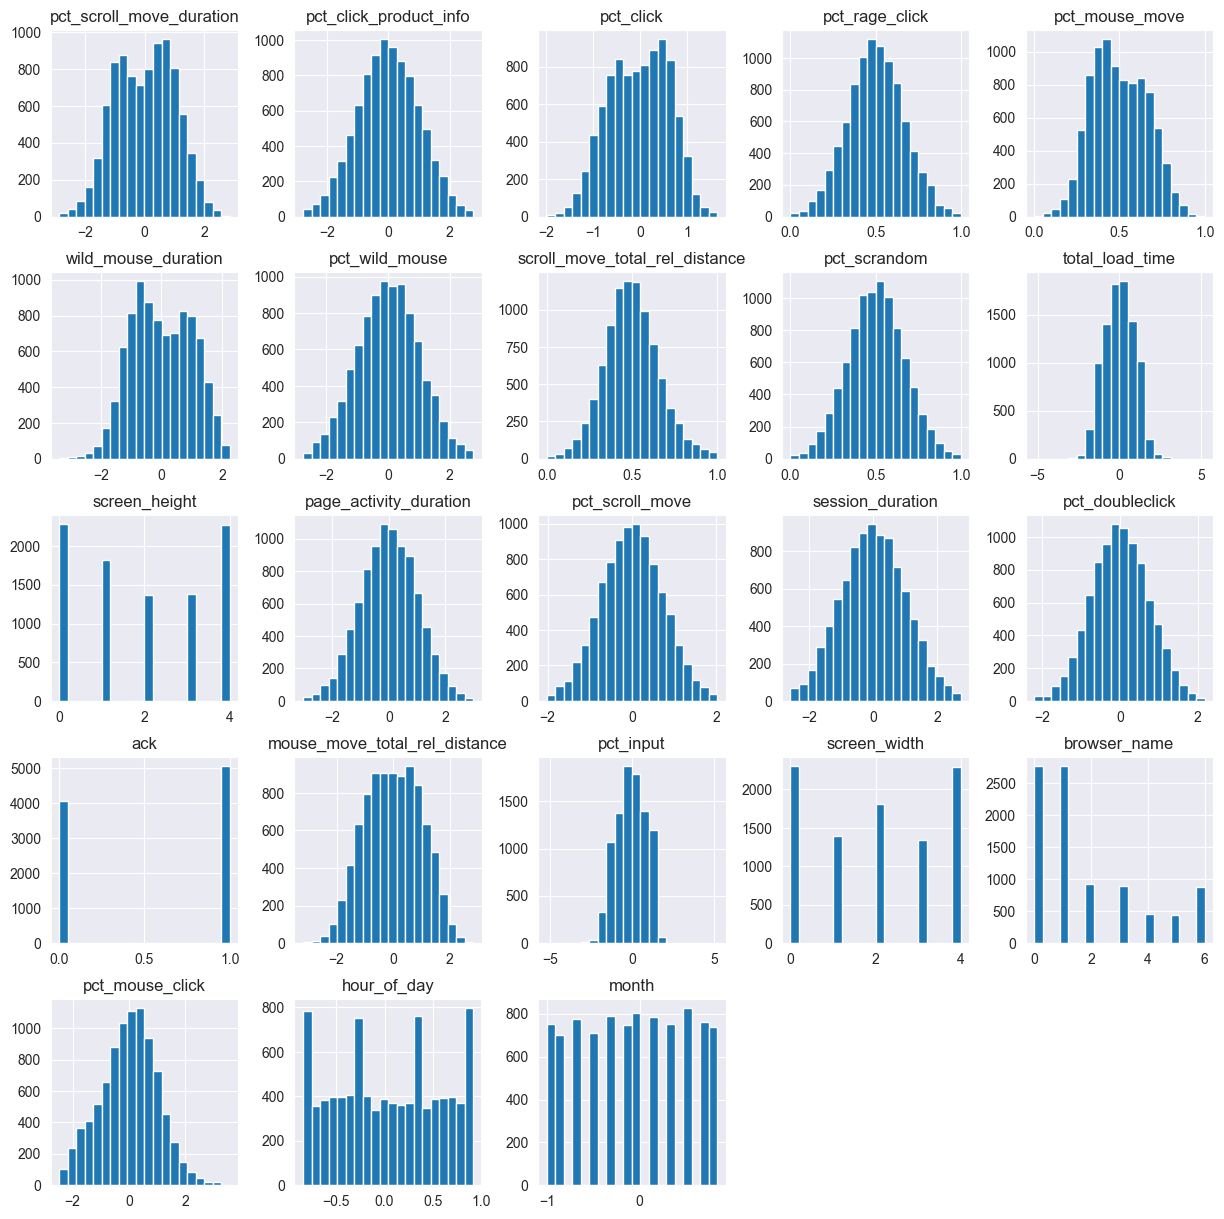

In [94]:
train_data.hist(bins=20, figsize=(15, 15))
plt.show()

## Výber atribútov pre strojové učenie
Na účely selekcie atribútov, ktoré najviac prispievajú k predikovanej premennej, sme sa rozhodli porovnať dva prístupy a následne zoradiť atribúty od najdôležitejších po najmenej dôležité:
* Select K Best
* Recursive Feature Elimination
    
### Select K Best
Bezkontextový výber, ktorý pozerá iba na koreláciu atribútu s `ack` a priradí im na základe toho skóre, následne je jednoduché atribúty zoradiť a vyberať `k=5` najdôležitejších atribútov.  

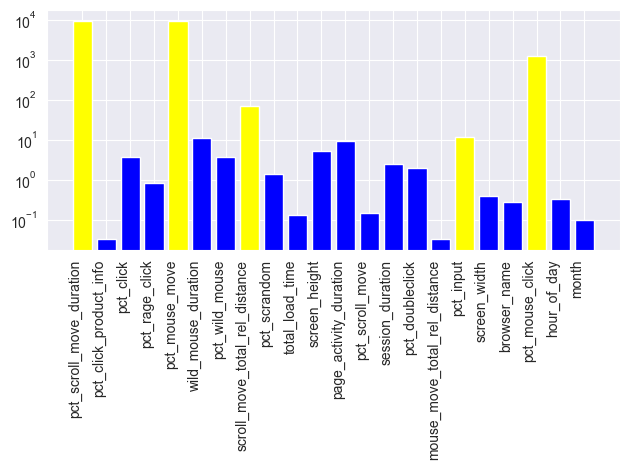

['pct_mouse_move', 'pct_scroll_move_duration', 'pct_mouse_click', 'scroll_move_total_rel_distance', 'pct_input']


In [95]:
X = train_data.drop('ack', axis=1)
y = train_data['ack']

k_best = SelectKBest(score_func=f_classif, k=5)
k_best.fit_transform(X, y)

def visualize_kbest(X, k_best, base_color='blue', chosen_color='yellow', top_k=5):
    top_k_indices = np.argsort(k_best.scores_)[-top_k:]

    colors = [chosen_color if i in top_k_indices else base_color for i in range(len(k_best.scores_))]

    plt.bar(range(len(X.columns)), k_best.scores_, color=colors)
    plt.xticks(range(len(X.columns)), X.columns, rotation='vertical', ha="right")
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    feature_scores_list = list(zip(X.columns, k_best.scores_))
    feature_scores_list.sort(key=lambda x: x[1], reverse=True)
    print([feature for feature, score in feature_scores_list[:5]])

visualize_kbest(X, k_best)

### Recursive Feature Elimination
Kontextový výber najdôležitejších atribútov, teda narozdiel od Select K Best sa táto metóda pozerá na atribúty v kontexte ostatných atribútov a na základe toho vyhodnocuje jeho vplyv na `ack`. Táto metóda postupne eliminuje menej dôležité atribúty z datasetu až dokým nenájde `k=5` najdôležitejších. Model, ktorý Recursive Feature Elimination pri výbere využíva môže byť rôzny my sme sa rozhodli pre `RandomForestClassifier`, pretože zabezpečuje presnosť.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()  
rfe = RFE(model, n_features_to_select=5) 
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print(list(selected_features))

['pct_scroll_move_duration', 'pct_mouse_move', 'wild_mouse_duration', 'pct_input', 'pct_mouse_click']


## Overenie pomocou heat mapy
Metódy výberu atribútov pre strojové učenie dokážeme porovnať medzi sebou, no i za pomoci heat mapy. 

<Axes: >

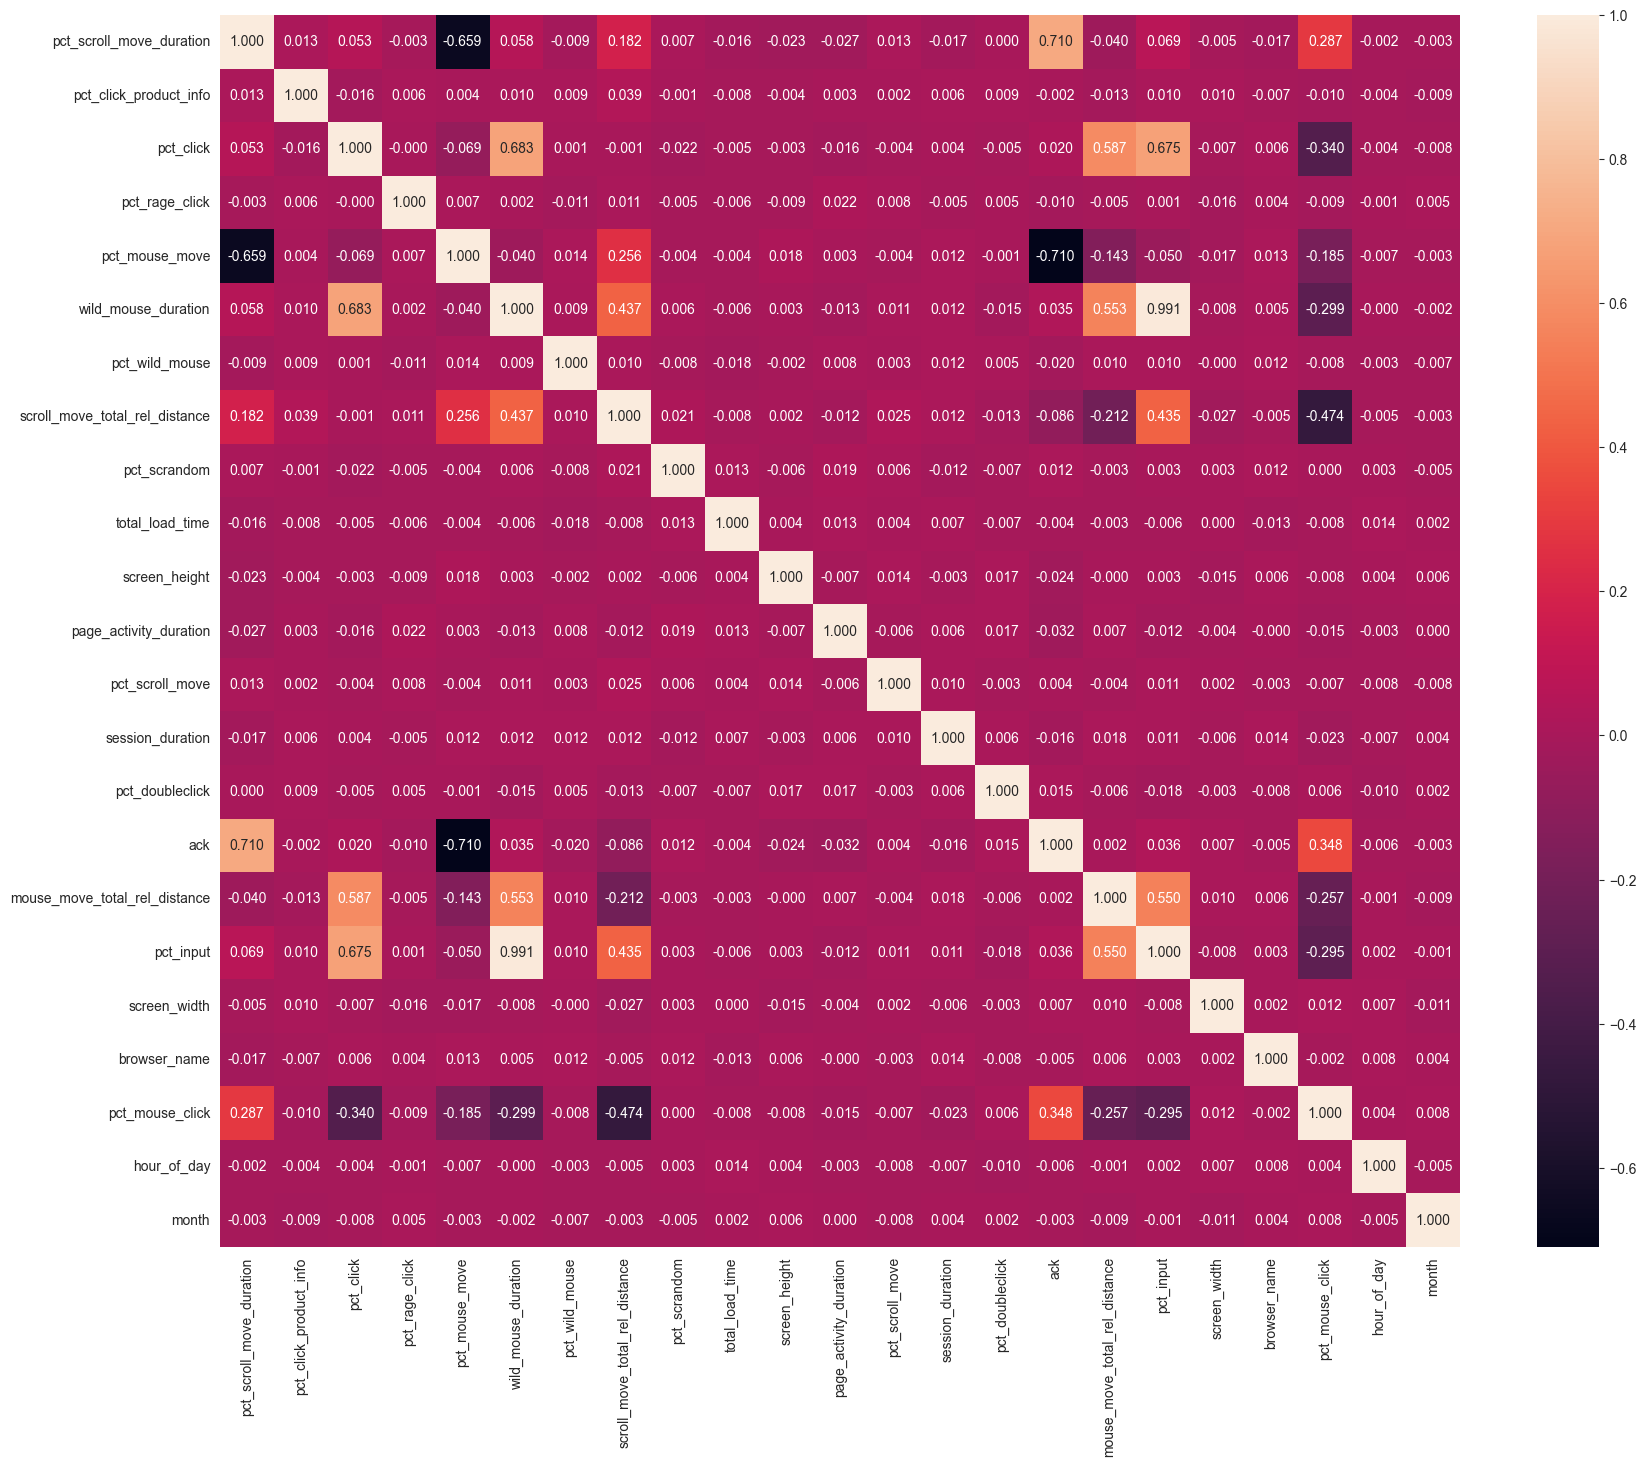

In [97]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(train_data.corr(),ax=ax, annot =True, fmt = ".3f")

# Replikovateľnosť predspracovania
Urobíme si dve pipeliny:
* train data - v poslednej fáze prejde výberom zaujímavých atribútov na základe RFE, ktorý sa nám zaručil ako efektívnejší
* test data - v poslednej fáze sú ponechané iba atribúty, ktoré boli vybrané z train data

Zavoláme mierne upravené funkcie, ktoré sme si počas tohto projektu pripravili. 
* funkcie pre label encoding prešli zmenou, kedy sú hodnoty menenné na základe dictionary a následne znormalizované, aby ich hodnoty nadobúdali 0,1
* funkcie pre scalery boli prispôsobené modularite 

Následne train data a test data uložíme do .\27\.csv.

[Pipeline] ....... (step 1 of 18) Processing drop_extra, total=   0.0s
[Pipeline]  (step 2 of 18) Processing process_screen_sizes, total=   0.0s
[Pipeline]  (step 3 of 18) Processing label_encoding_height, total=   0.0s
[Pipeline]  (step 4 of 18) Processing label_encoding_width, total=   0.0s
[Pipeline]  (step 5 of 18) Processing label_encoding_browser, total=   0.0s
[Pipeline]  (step 6 of 18) Processing process_session_start, total=   0.0s
[Pipeline]  (step 7 of 18) Processing replace_null_with_knn, total=   0.0s
[Pipeline]  (step 8 of 18) Processing replace_null_with_median, total=   0.0s
[Pipeline]  (step 9 of 18) Processing replace_null_with_mean, total=   0.0s
[Pipeline]  (step 10 of 18) Processing convert_columns_to_float64, total=   0.7s
[Pipeline]  (step 11 of 18) Processing remove_negative_session_duration, total=   0.0s
[Pipeline]  (step 12 of 18) Processing remove_outliers_std, total=   0.0s
[Pipeline]  (step 13 of 18) Processing remove_outliers_iqr, total=   0.0s
[Pipeline]

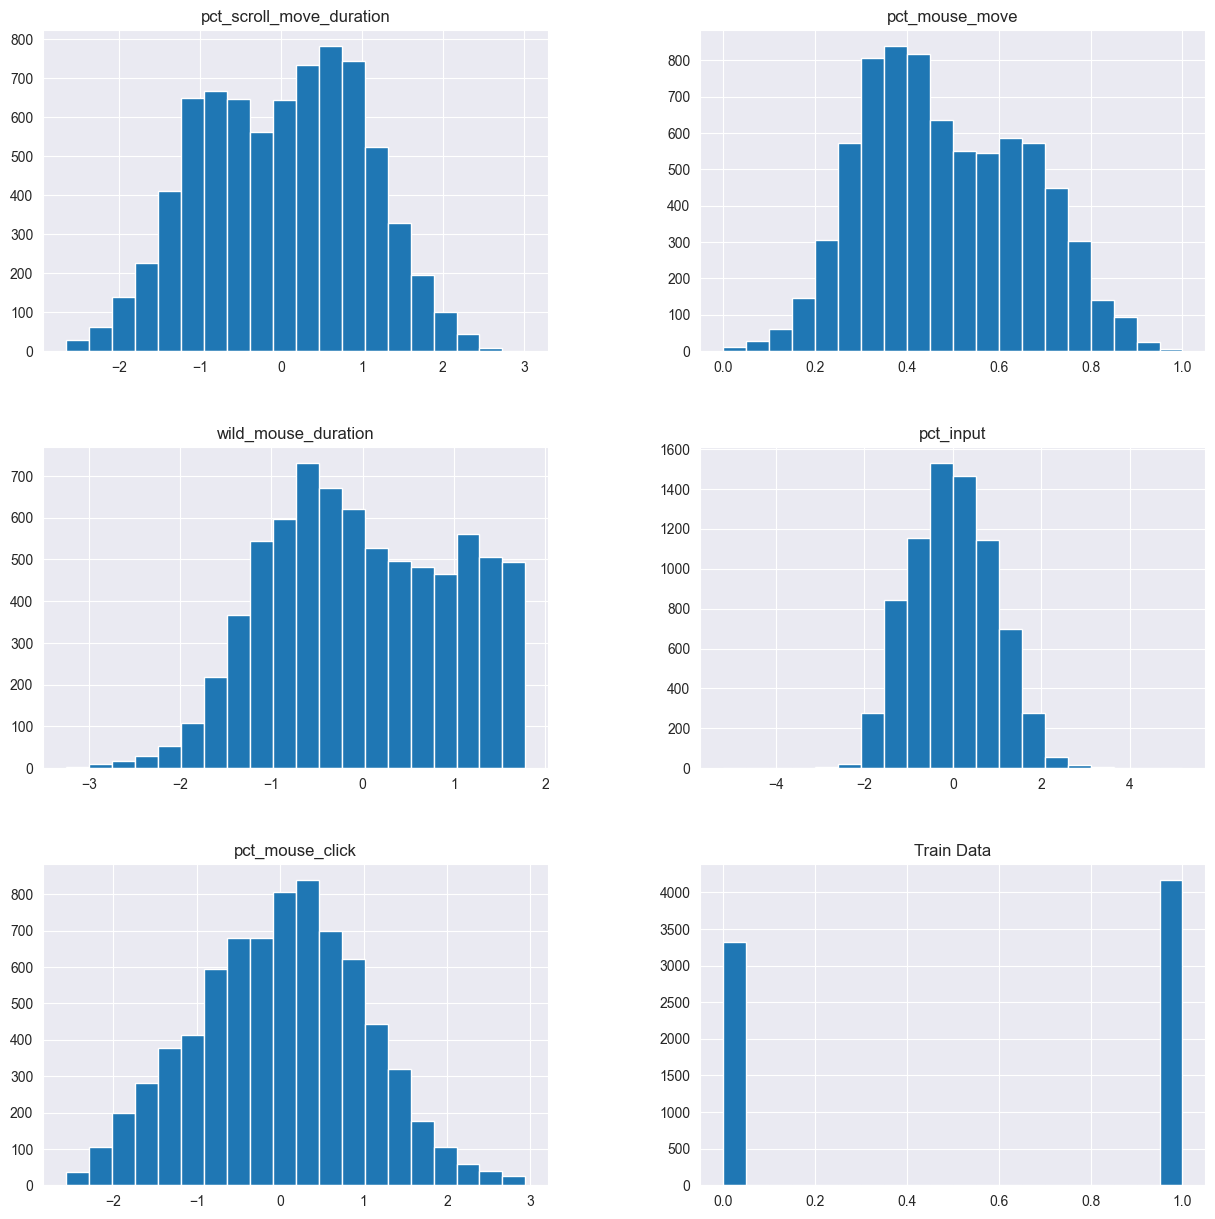

[Pipeline] ....... (step 1 of 18) Processing drop_extra, total=   0.0s
[Pipeline]  (step 2 of 18) Processing process_screen_sizes, total=   0.0s
[Pipeline]  (step 3 of 18) Processing label_encoding_height, total=   0.0s
[Pipeline]  (step 4 of 18) Processing label_encoding_width, total=   0.0s
[Pipeline]  (step 5 of 18) Processing label_encoding_browser, total=   0.0s
[Pipeline]  (step 6 of 18) Processing process_session_start, total=   0.0s
[Pipeline]  (step 7 of 18) Processing replace_null_with_knn, total=   0.0s
[Pipeline]  (step 8 of 18) Processing replace_null_with_median, total=   0.0s
[Pipeline]  (step 9 of 18) Processing replace_null_with_mean, total=   0.0s
[Pipeline]  (step 10 of 18) Processing convert_columns_to_float64, total=   0.1s
[Pipeline]  (step 11 of 18) Processing remove_negative_session_duration, total=   0.0s
[Pipeline]  (step 12 of 18) Processing remove_outliers_std, total=   0.0s
[Pipeline]  (step 13 of 18) Processing remove_outliers_iqr, total=   0.0s
[Pipeline]

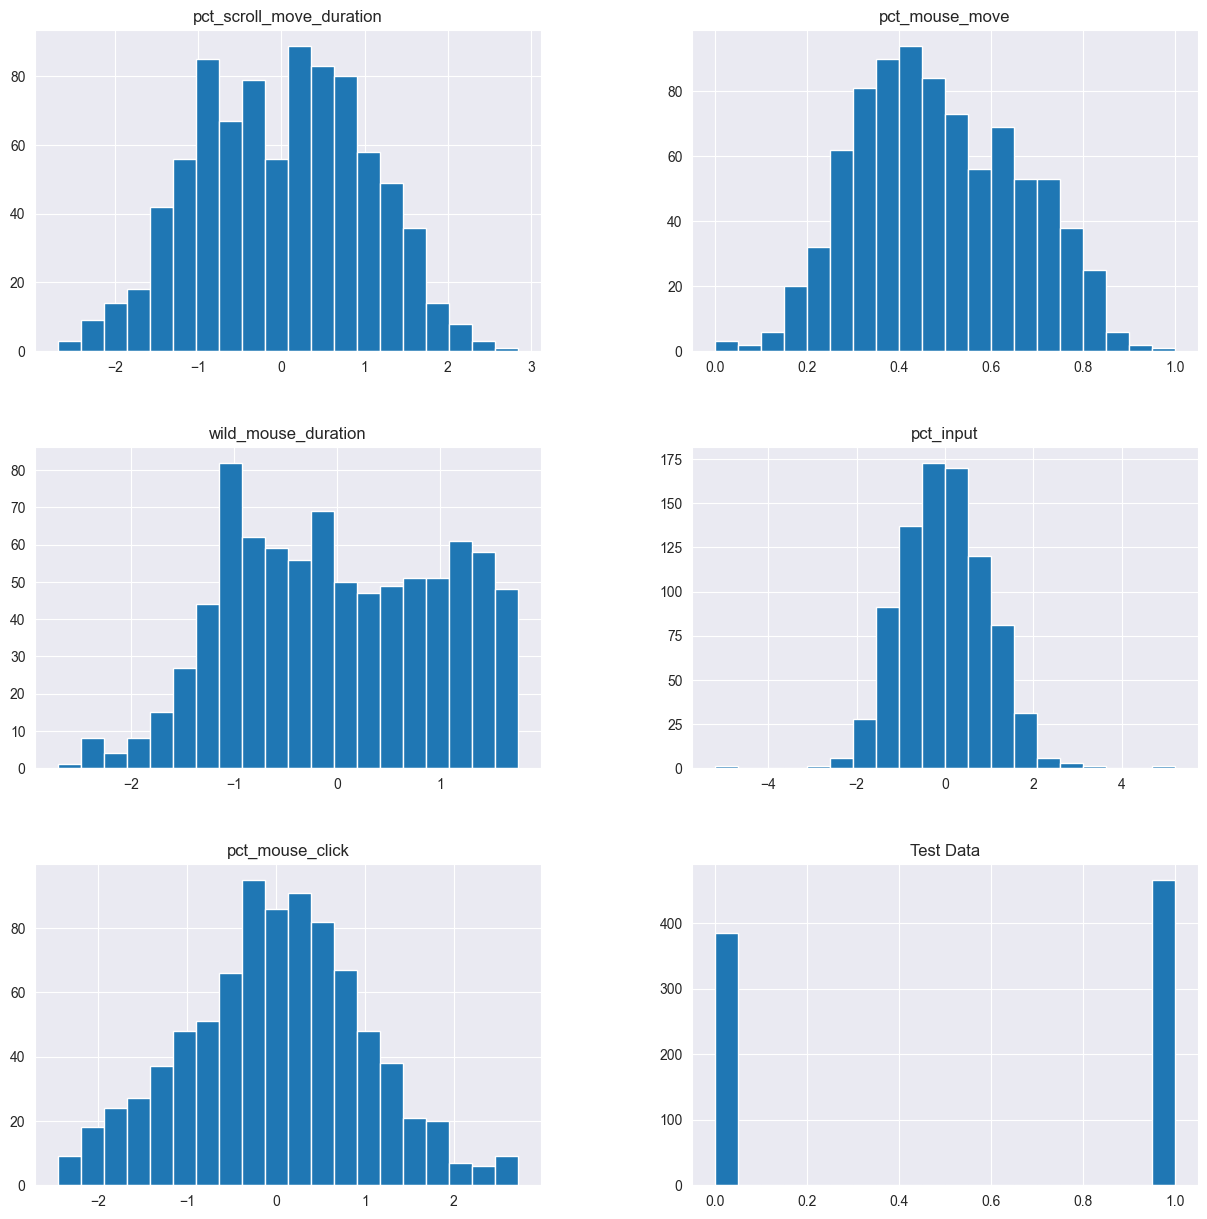

In [98]:
def drop_extra(dataframe):
    return dataframe.drop_duplicates().drop(columns=['product_ean', 'session_id', 'user_id'])

def label_encoding(dataframe, column, mapping):
    max_original_value = max(mapping.values())
    normalized_mapping = {key: value / max_original_value for key, value in mapping.items()}
    dataframe[column] = dataframe[column].replace(normalized_mapping)
    return dataframe

def label_encoding_width(dataframe):
    resolution_mapping = {800: 0, 1024: 1, 1280: 2, 1366: 3, 1920: 4}
    return label_encoding(dataframe, 'screen_width', resolution_mapping)

def label_encoding_height(dataframe):
    resolution_mapping = {600: 0, 768: 1, 800: 2, 1024: 3, 1080: 4}
    return label_encoding(dataframe, 'screen_height', resolution_mapping)

def label_encoding_browser(dataframe):
    browser_mapping = {'other': 0, 'edge': 1, 'chrome': 2, 'firefox': 3, 'safari': 4, 'opera': 5, 'mobile': 6}
    return label_encoding(dataframe, 'browser_name', browser_mapping)

def process_session_screen_sizes(dataframe):
    screen_width_data = list(dataframe["screen_width"].unique())
    screen_width_numeric_values = [int(value) for value in screen_width_data if value.isdigit()]
    min_width = str(min(screen_width_numeric_values, default=None))
    max_width = str(max(screen_width_numeric_values, default=None))

    screen_height_data = list(dataframe["screen_height"].unique())
    screen_height_numeric_values = [int(value) for value in screen_height_data if value.isdigit()]
    min_height = str(min(screen_height_numeric_values, default=None))
    max_height= str(max(screen_height_numeric_values, default=None))

    dataframe["screen_width"]=dataframe["screen_width"].str.replace("lower", min_width)
    dataframe["screen_width"]=dataframe["screen_width"].str.replace("higher", max_width)
    dataframe["screen_height"]=dataframe["screen_height"].str.replace("lower", min_height)
    dataframe["screen_height"]=dataframe["screen_height"].str.replace("higher", max_height)

    dataframe["screen_height"] = pd.to_numeric(dataframe["screen_height"], errors='coerce')
    dataframe["screen_width"] = pd.to_numeric(dataframe["screen_width"], errors='coerce')
    return dataframe

def process_session_start(dataframe):
    dataframe['session_start'] = pd.to_datetime(dataframe['session_start'])
    dataframe['hour_of_day'] = dataframe['session_start'].dt.hour
    dataframe['month'] = dataframe['session_start'].dt.month
    return dataframe.drop(columns=['session_start'])

def convert_columns_to_float64(dataframe):
    return dataframe.applymap(lambda x: pd.to_numeric(x, errors='coerce')).astype('float64')

def remove_negative_session_duration(dataframe):
    return dataframe[dataframe['session_duration'] >= 0]

def replace_null_with_knn(dataframe, columns_with_missing_values):
    imputed_values = KNNImputer().fit_transform(dataframe[columns_with_missing_values])

    for i, column in enumerate(columns_with_missing_values):
        dataframe[column] = imputed_values[:, i]
    return dataframe

def replace_null_with_median(dataframe, columns_with_missing_values):
    median_values = dataframe[columns_with_missing_values].median()
    result_dataframe = dataframe.copy()
    result_dataframe[columns_with_missing_values] = result_dataframe[columns_with_missing_values].fillna(median_values)
    return result_dataframe

def replace_null_with_mean(dataframe, columns_with_missing_values):
    mean_values = dataframe[columns_with_missing_values].mean()
    result_dataframe = dataframe.copy()
    result_dataframe[columns_with_missing_values] = result_dataframe[columns_with_missing_values].fillna(mean_values)
    return result_dataframe

def remove_outliers_std(dataframe, columns):
    cleaned_dataframe = dataframe.copy()

    for column in columns:
        column_mean, column_std = np.mean(cleaned_dataframe[column]), np.std(cleaned_dataframe[column])
        low = column_mean - column_std * 3
        high = column_mean + column_std * 3
        cleaned_dataframe = cleaned_dataframe.loc[(cleaned_dataframe[column] > low) & (cleaned_dataframe[column] < high)]

    return cleaned_dataframe

def remove_outliers_iqr(dataframe, columns, threshold=1.5):
    cleaned_dataframe = dataframe.copy()

    for column_name in columns:
        Q1 = cleaned_dataframe[column_name].quantile(0.25)
        Q3 = cleaned_dataframe[column_name].quantile(0.75)
        IQR = Q3 - Q1

        outliers = (cleaned_dataframe[column_name] < (Q1 - threshold * IQR)) | (cleaned_dataframe[column_name] > (Q3 + threshold * IQR))
        cleaned_dataframe = cleaned_dataframe.loc[~outliers]

    return cleaned_dataframe

def apply_scaler(dataframe, column_name, scaler):
    dataframe[column_name] = scaler.fit_transform(dataframe[[column_name]])
    return dataframe

def apply_scaler_to_columns(dataframe, columns, scaler):
    for column in columns:
        dataframe = apply_scaler(dataframe, column, scaler)
    return dataframe

def apply_feature_selection(dataframe, apply_selection_flag):
    if not apply_selection_flag:
        return dataframe

    X = dataframe.drop('ack', axis=1)
    y = dataframe['ack']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=5)
    rfe.fit(X_train, y_train)

    selected_features = list(X.columns[rfe.support_])
    selected_features.append('ack')
    return dataframe[selected_features]

def remove_all_but_selected(dataframe, selected_columns):
    return dataframe[selected_columns]

def define_null_cols():
    null_cols = ["pct_scroll_move_duration", "pct_click_product_info", "pct_click", "pct_rage_click", "pct_mouse_move", "wild_mouse_duration", "pct_wild_mouse", "scroll_move_total_rel_distance", "pct_scrandom", "total_load_time", "screen_height", "page_activity_duration", "pct_scroll_move", "session_duration", "pct_doubleclick", "ack", "mouse_move_total_rel_distance", "pct_input", "screen_width", "browser_name", "pct_mouse_click"]
    return np.array_split(null_cols, 3)

def define_outlier_cols():
    outlier_columns = ["pct_scroll_move_duration", "pct_click_product_info", "pct_click", "pct_rage_click", "pct_mouse_move", "wild_mouse_duration", "pct_wild_mouse", "scroll_move_total_rel_distance", "pct_scrandom", "total_load_time", "page_activity_duration", "pct_scroll_move", "session_duration", "pct_doubleclick", "mouse_move_total_rel_distance", "pct_input", "pct_mouse_click"]
    return np.array_split(outlier_columns, 2)

def replicate_preprocessing():
    sessions = pd.read_csv("027/session.csv", encoding="utf_8", sep='\t')
    train_data, test_data= train_test_split(sessions, test_size=0.1, random_state=1)

    knn_cols, median_cols, mean_cols = define_null_cols()
    outliers1, outliers2 = define_outlier_cols()

    quantile_columns = ["pct_input", "total_load_time"]
    transformer_columns = ["pct_scroll_move_duration", "wild_mouse_duration", "mouse_move_total_rel_distance", "pct_mouse_click"]
    minmax_columns = ["pct_rage_click", "pct_mouse_move", "scroll_move_total_rel_distance", "pct_scrandom"]
    robust_columns = ["pct_click", "pct_scroll_move", "pct_doubleclick", "hour_of_day", "month"]
    standard_columns = ["pct_click_product_info", "pct_wild_mouse", "page_activity_duration", "session_duration"]

    init_pipeline = Pipeline([
        ('drop_extra', FunctionTransformer(drop_extra)),
        ('process_screen_sizes', FunctionTransformer(process_session_screen_sizes)),
        ('label_encoding_height', FunctionTransformer(label_encoding_height)),
        ('label_encoding_width', FunctionTransformer(label_encoding_width)),
        ('label_encoding_browser', FunctionTransformer(label_encoding_browser)),
        ('process_session_start', FunctionTransformer(process_session_start)),
        ('replace_null_with_knn', FunctionTransformer(remove_outliers_std, kw_args={"columns": knn_cols})),
        ('replace_null_with_median', FunctionTransformer(remove_outliers_std, kw_args={"columns": median_cols})),
        ('replace_null_with_mean', FunctionTransformer(remove_outliers_std, kw_args={"columns": mean_cols})),
        ('convert_columns_to_float64', FunctionTransformer(convert_columns_to_float64)),
        ('remove_negative_session_duration', FunctionTransformer(remove_negative_session_duration)),
        ('remove_outliers_std', FunctionTransformer(remove_outliers_std, kw_args={"columns": outliers1})),
        ('remove_outliers_iqr', FunctionTransformer(remove_outliers_iqr, kw_args={"columns": outliers2})),
        ('quantile', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": quantile_columns, "scaler": QuantileTransformer(output_distribution="normal", n_quantiles=10, random_state=42)})),
        ('power', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": transformer_columns, "scaler": PowerTransformer()})),
        ('minmax', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": minmax_columns, "scaler": MinMaxScaler()})),
        ('robust', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": robust_columns, "scaler": RobustScaler()})),
        ('standard', FunctionTransformer(apply_scaler_to_columns, kw_args={"columns": standard_columns, "scaler": StandardScaler()}))
    ], verbose=True)

    train_pipeline =  Pipeline([
        ('feature_selection', FunctionTransformer(apply_feature_selection, kw_args={"apply_selection_flag": True}))
    ], verbose=True)

    train_data_processed = init_pipeline.fit_transform(train_data)
    train_data_processed = train_pipeline.fit_transform(train_data_processed)
    selected = train_data_processed.columns

    train_data_processed.hist(bins=20, figsize=(15, 15))
    plt.title('Train Data')
    plt.show()

    test_pipeline =  Pipeline([
        ('remove_all_but_selected', FunctionTransformer(remove_all_but_selected, kw_args={"selected_columns": selected}))
    ], verbose=True)


    test_data_processed = init_pipeline.fit_transform(test_data)
    test_data_processed = test_pipeline.fit_transform(test_data_processed)
    test_data_processed.hist(bins=20, figsize=(15, 15))
    plt.title('Test Data')
    plt.show()

    train_data_processed.to_csv("027/train_data.csv", encoding="utf_8", sep='\t', index=False)
    test_data_processed.to_csv("027/test_data.csv", encoding="utf_8", sep='\t', index=False)

replicate_preprocessing()